In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip3 install neurite
%cd "/content/drive/MyDrive/Colab Notebooks/Radiology/MSK-Image-Registration"
!ls

/content/drive/MyDrive/Colab Notebooks/Radiology/MSK-Image-Registration
 affineRegNN2_debug.ipynb	    layers.py
 affineRegNN3_data1_svd_rot.ipynb   model_img
 affineRegNN4_data2.ipynb	    MRNet
 affineRegNN_archive.ipynb	    prototype.py
 affine_training_data_gen.ipynb     __pycache__
 baseline_DLIR_v2.png		    utils.py
 checkpoints			   'VoxelMorph Demo.ipynb'
 data				    VoxelMorphNetworkStructure1.png
 generate_data2.m		    VoxelMorphNetworkStructure2.png


In [ ]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
# import scipy
import time
from tqdm.notebook import tqdm
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import random
from keras import backend as K

In [ ]:
import layers as custom_layers

In [ ]:
# We renamed cusolver64_11.dll to cusolver64_10.dll to solve the compatibility issue.
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

Num GPUs Available:  1


In [ ]:
# File Paths
# imgIdxCsvPath = './MRNet/MRNet-v1.0/similar.csv'
# MRI_Path = './MRNet/MRNet-v1.0/train/axial/{}.npy'
# MRI_Path = "/content/drive/MyDrive/Colab Notebooks/Radiology/MSK-Image-Registration/data/test_data/{}.npy"

## Load self-generated training data (by data loaders)

### Duplicate fixed image as labels

In [ ]:
# trainDataPath = "./data/affineTrainingData/affine{}.npz"
# trainDataPath = "./data/affineTrainingData_SVD_Rot/affine{}.npz"
trainDataPath = "./data/affineTrainingData2/affine{}.npz"
trainDataSize = 1500
# fixedImg = np.load(MRI_Path.format("0701"))
# fixedImg = fixedImg / np.max(fixedImg)
# fixedImg = np.expand_dims(fixedImg, axis=-1)
# fixedImg = np.expand_dims(fixedImg, axis=0)

fixed_depth = 64
fixed_input_shape = (1, fixed_depth, 256, 256, 1)

def data_generator(batchSize = 1, trainDataSize=1000):
    assert batchSize > 0
    if batchSize == 1:
        while True:
            idx = random.randrange(trainDataSize)
            inputObj = np.load(trainDataPath.format(idx))
            fixedImg = inputObj["fixedImg"]
            movingImg = inputObj["movingImg"]
            # movingImg = np.expand_dims(movingImg, axis=-1)
            # movingImg = np.expand_dims(movingImg, axis=0)

            # # pad
            # depth = fixedImg.shape[1]
            # up_pad = (fixed_depth-depth)//2
            # down_pad = fixed_depth-depth - up_pad
            # fixedImg = np.pad(fixedImg, pad_width=((0,0),(up_pad,down_pad),(0,0),(0,0),(0,0)), 
            #                  mode="constant", constant_values=0)
            # movingImg = np.pad(movingImg, pad_width=((0,0),(up_pad,down_pad),(0,0),(0,0),(0,0)), 
            #                  mode="constant", constant_values=0)

            imgPair = np.concatenate([movingImg, fixedImg], axis=4)
            tgtAffineTrf = inputObj['trf']
            tgtAffineTrf = np.expand_dims(tgtAffineTrf, axis=0)
            
            yield (imgPair, [fixedImg, tgtAffineTrf])
    else:
        while True:
            imgPairs = []
            fixedImgs = []
            tgtAffineTrfs = []
            for _ in range(batchSize):
                idx = random.randrange(trainDataSize)
                inputObj = np.load(trainDataPath.format(idx))
                fixedImg = inputObj["fixedImg"]
                movingImg = inputObj["movingImg"]
                # movingImg = np.expand_dims(movingImg, axis=-1)
                # movingImg = np.expand_dims(movingImg, axis=0)

                # # pad
                # depth = fixedImg.shape[1]
                # up_pad = (fixed_depth-depth)//2
                # down_pad = fixed_depth-depth - up_pad
                # fixedImg = np.pad(fixedImg, pad_width=((0,0),(up_pad,down_pad),(0,0),(0,0),(0,0)), 
                #                 mode="constant", constant_values=0)
                # movingImg = np.pad(movingImg, pad_width=((0,0),(up_pad,down_pad),(0,0),(0,0),(0,0)), 
                #                 mode="constant", constant_values=0)

                imgPair = np.concatenate([movingImg, fixedImg], axis=4)
                tgtAffineTrf = inputObj['trf']
                tgtAffineTrf = np.expand_dims(tgtAffineTrf, axis=0)

                imgPairs.append(imgPair)
                fixedImgs.append(fixedImg)
                tgtAffineTrfs.append(tgtAffineTrf)
            
            imgPairs = np.concatenate(imgPairs, axis=0)
            fixedImgs = np.concatenate(fixedImgs, axis=0)
            tgtAffineTrfs = np.concatenate(tgtAffineTrfs, axis=0)
            yield (imgPairs, [fixedImgs, tgtAffineTrfs])

### Explore data

In [ ]:
dg = data_generator(4)
imgPairs, [fixedImgs, tgtAffineTrfs] = next(dg)
imgPairs.shape, fixedImgs.shape, tgtAffineTrfs.shape

((4, 64, 256, 256, 2), (4, 64, 256, 256, 1), (4, 12))

In [ ]:
# range 0~1
imgPairs.max()

1.0000001192092896

In [ ]:
## old data: mean mse img diff of 200 samples: 0.056
## new data: mean mse img diff of 500 samples: 0.03647
dg = data_generator()
# for x in dg:
#     break
# imgPair, [fixedImg, tgtAffineTrf] = x
# imgPair.shape # (1, 52, 256, 256, 2)

# ((imgPair[0,..., 0] - imgPair[0,..., 1])**2).mean()

count = 500
mean_mse = 0
for _ in tqdm(range(count)):
    imgPair, [fixedImg, tgtAffineTrf] = next(dg)
    diff = ((imgPair[0,..., 0] - imgPair[0,..., 1])**2).mean()
    mean_mse += diff
print(mean_mse/count)

  0%|          | 0/500 [00:00<?, ?it/s]

0.03647196479138947


In [ ]:
# check mean trf
def data_generator(batchSize = 1):
    # TODO: Batchify the funciton.
    for idx in range(2000):
        # idx = random.randrange(trainDataSize)
        inputObj = np.load(trainDataPath.format(idx))
        movingImg = inputObj['img']
        movingImg = np.expand_dims(movingImg, axis=-1)
        movingImg = np.expand_dims(movingImg, axis=0)
        imgPair = np.concatenate([movingImg, fixedImg], axis=4)

        tgtAffineTrf = inputObj['trf']
        tgtAffineTrf = np.expand_dims(tgtAffineTrf, axis=0)
        yield (imgPair, [fixedImg, tgtAffineTrf])

dataGen = data_generator()
trfs = []
for moving_test, (fixed, gt_trf) in tqdm(dataGen, total=2000):
    trfs.append(gt_trf)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
np.mean(trfs, axis=0)

array([[  1.00689002,   0.03654493,   0.03717216,  -3.63084558,
         -0.03239803,   0.99700621,  -0.10274288, -13.29430743,
         -0.0404979 ,   0.10132211,   0.9975384 , -16.55750802]])

## Train models

#### Baseline: direct affine matrix prediction

In [ ]:
## Modified model
## 1. use lrelu for all relu

# Change the channel dimension to get the image pair shape
# imgPairShape = list(fixedImg.shape)[1:]
imgPairShape = list(fixed_input_shape)[1:]
imgPairShape[-1] = 2
inputs = keras.Input(shape = imgPairShape)
moving_input = tf.expand_dims(inputs[:, :, :, :, 0], axis = -1)
fixed_input = tf.expand_dims(inputs[:, :, :, :, 1], axis = -1)

down_depths = [4, 8, 16, 24, 32]
# up_depths = [2, 16, 32, 16, 3]
lrelu = layers.LeakyReLU(alpha=0.1)

conv_0 = layers.Conv3D(filters=down_depths[0], kernel_size=(6, 32, 32), strides=(1, 2, 2), activation=lrelu)(moving_input)
print("conv_0: {}".format(conv_0.shape))
conv_1 = layers.Conv3D(filters=down_depths[1], kernel_size=(6, 16, 16), activation=lrelu)(conv_0)
print("conv_1: {}".format(conv_1.shape))
filtered_conv_1 = layers.MaxPool3D((2, 2, 2))(conv_1)
print("filtered_conv_1: {}".format(filtered_conv_1.shape))
conv_2 = layers.Conv3D(filters=down_depths[2], kernel_size=(6, 8, 8), activation=lrelu)(filtered_conv_1)
print("conv_2: {}".format(conv_2.shape))
filtered_conv_2 = layers.MaxPool3D((1, 2, 2))(conv_2)
print("filtered_conv_2: {}".format(filtered_conv_2.shape))
conv_3 = layers.Conv3D(filters=down_depths[3], kernel_size=(4, 8, 8), activation=lrelu)(filtered_conv_2)
print("conv_3: {}".format(conv_3.shape))
conv_4 = layers.Conv3D(filters=down_depths[4], kernel_size=(4, 4, 4), activation=lrelu)(conv_3)
print("conv_4: {}".format(conv_4.shape))

f_conv_0 = layers.Conv3D(filters=down_depths[0], kernel_size=(6, 32, 32), strides=(1, 2, 2), activation=lrelu)(fixed_input)
f_conv_1 = layers.Conv3D(filters=down_depths[1], kernel_size=(6, 16, 16), activation=lrelu)(f_conv_0)
f_filtered_conv_1 = layers.MaxPool3D((2, 2, 2))(f_conv_1)
f_conv_2 = layers.Conv3D(filters=down_depths[2], kernel_size=(6, 8, 8), activation=lrelu)(f_filtered_conv_1)
f_filtered_conv_2 = layers.MaxPool3D((1, 2, 2))(f_conv_2)
f_conv_3 = layers.Conv3D(filters=down_depths[3], kernel_size=(4, 8, 8), activation=lrelu)(f_filtered_conv_2)
f_conv_4 = layers.Conv3D(filters=down_depths[4], kernel_size=(4, 4, 4), activation=lrelu)(f_conv_3)

concat_feats = tf.concat([conv_4, f_conv_4], axis = -1)
print(concat_feats.shape)

flattened = layers.Flatten()(concat_feats)
dense_0 = layers.Dense(1024, activation=lrelu)(flattened)
dense_1 = layers.Dense(256, activation=lrelu)(dense_0)
dense_2 = layers.Dense(64, activation=lrelu)(dense_1)
affine_pred = layers.Dense(12, activation="linear", name="affine_pred")(dense_2)


# convTransposed_3 = layers.Conv3DTranspose(filters=up_depths[0], kernel_size=(6, 10, 10), activation="relu")(conv_4)
# print("convTransposed_3: {}".format(convTransposed_3.shape))
# filtered_convTransposed_2 = layers.Conv3DTranspose(filters=up_depths[1], kernel_size=(6, 20, 20), activation="relu")(convTransposed_3)
# print("filtered_convTransposed_2: {}".format(filtered_convTransposed_2.shape))
# convTransposed_2 = layers.UpSampling3D((1, 2, 2))(filtered_convTransposed_2)
# print("convTransposed_2: {}".format(convTransposed_2.shape))
# filtered_convTransposed_1 = layers.Conv3DTranspose(filters=up_depths[2], kernel_size=(3, 15, 15), activation="relu")(convTransposed_2)
# print("filtered_convTransposed_1: {}".format(filtered_convTransposed_1.shape))
# convTransposed_1 = layers.UpSampling3D((2, 2, 2))(filtered_convTransposed_1)
# print("convTransposed_1: {}".format(convTransposed_1.shape))
# convTransposed_0 = layers.Conv3DTranspose(filters=up_depths[3], kernel_size=(3, 16, 16), activation="relu")(convTransposed_1)
# print("convTransposed_0: {}".format(convTransposed_0.shape))
# deformation_field_pred = layers.Conv3DTranspose(filters=up_depths[4], kernel_size=(3, 10, 10), activation="relu")(convTransposed_0)
# print("deformation_field_pred: {}".format(deformation_field_pred.shape))

affine_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=True)([moving_input, affine_pred])
# deformable_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=False)([affine_warped, deformation_field_pred])
print(affine_warped.shape)

conv_0: (None, 59, 113, 113, 4)
conv_1: (None, 54, 98, 98, 8)
filtered_conv_1: (None, 27, 49, 49, 8)
conv_2: (None, 22, 42, 42, 16)
filtered_conv_2: (None, 22, 21, 21, 16)
conv_3: (None, 19, 14, 14, 24)
conv_4: (None, 16, 11, 11, 32)
(None, 16, 11, 11, 64)
(None, 64, 256, 256, 1)


In [ ]:
model = keras.Model(inputs=inputs, outputs=[affine_warped, affine_pred], name="baseline_model")
model.summary(line_length=150)

Model: "baseline_model"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_1 (InputLayer)                             [(None, 64, 256, 256, 2)]        0                                                                   
______________________________________________________________________________________________________________________________________________________
tf.__operators__.getitem_2 (SlicingOpLambda)     (None, 64, 256, 256)             0                 input_1[0][0]                                     
______________________________________________________________________________________________________________________________________________________
tf.__operators__.getitem_3 (SlicingOpLambda)     (None, 64, 256, 256) 

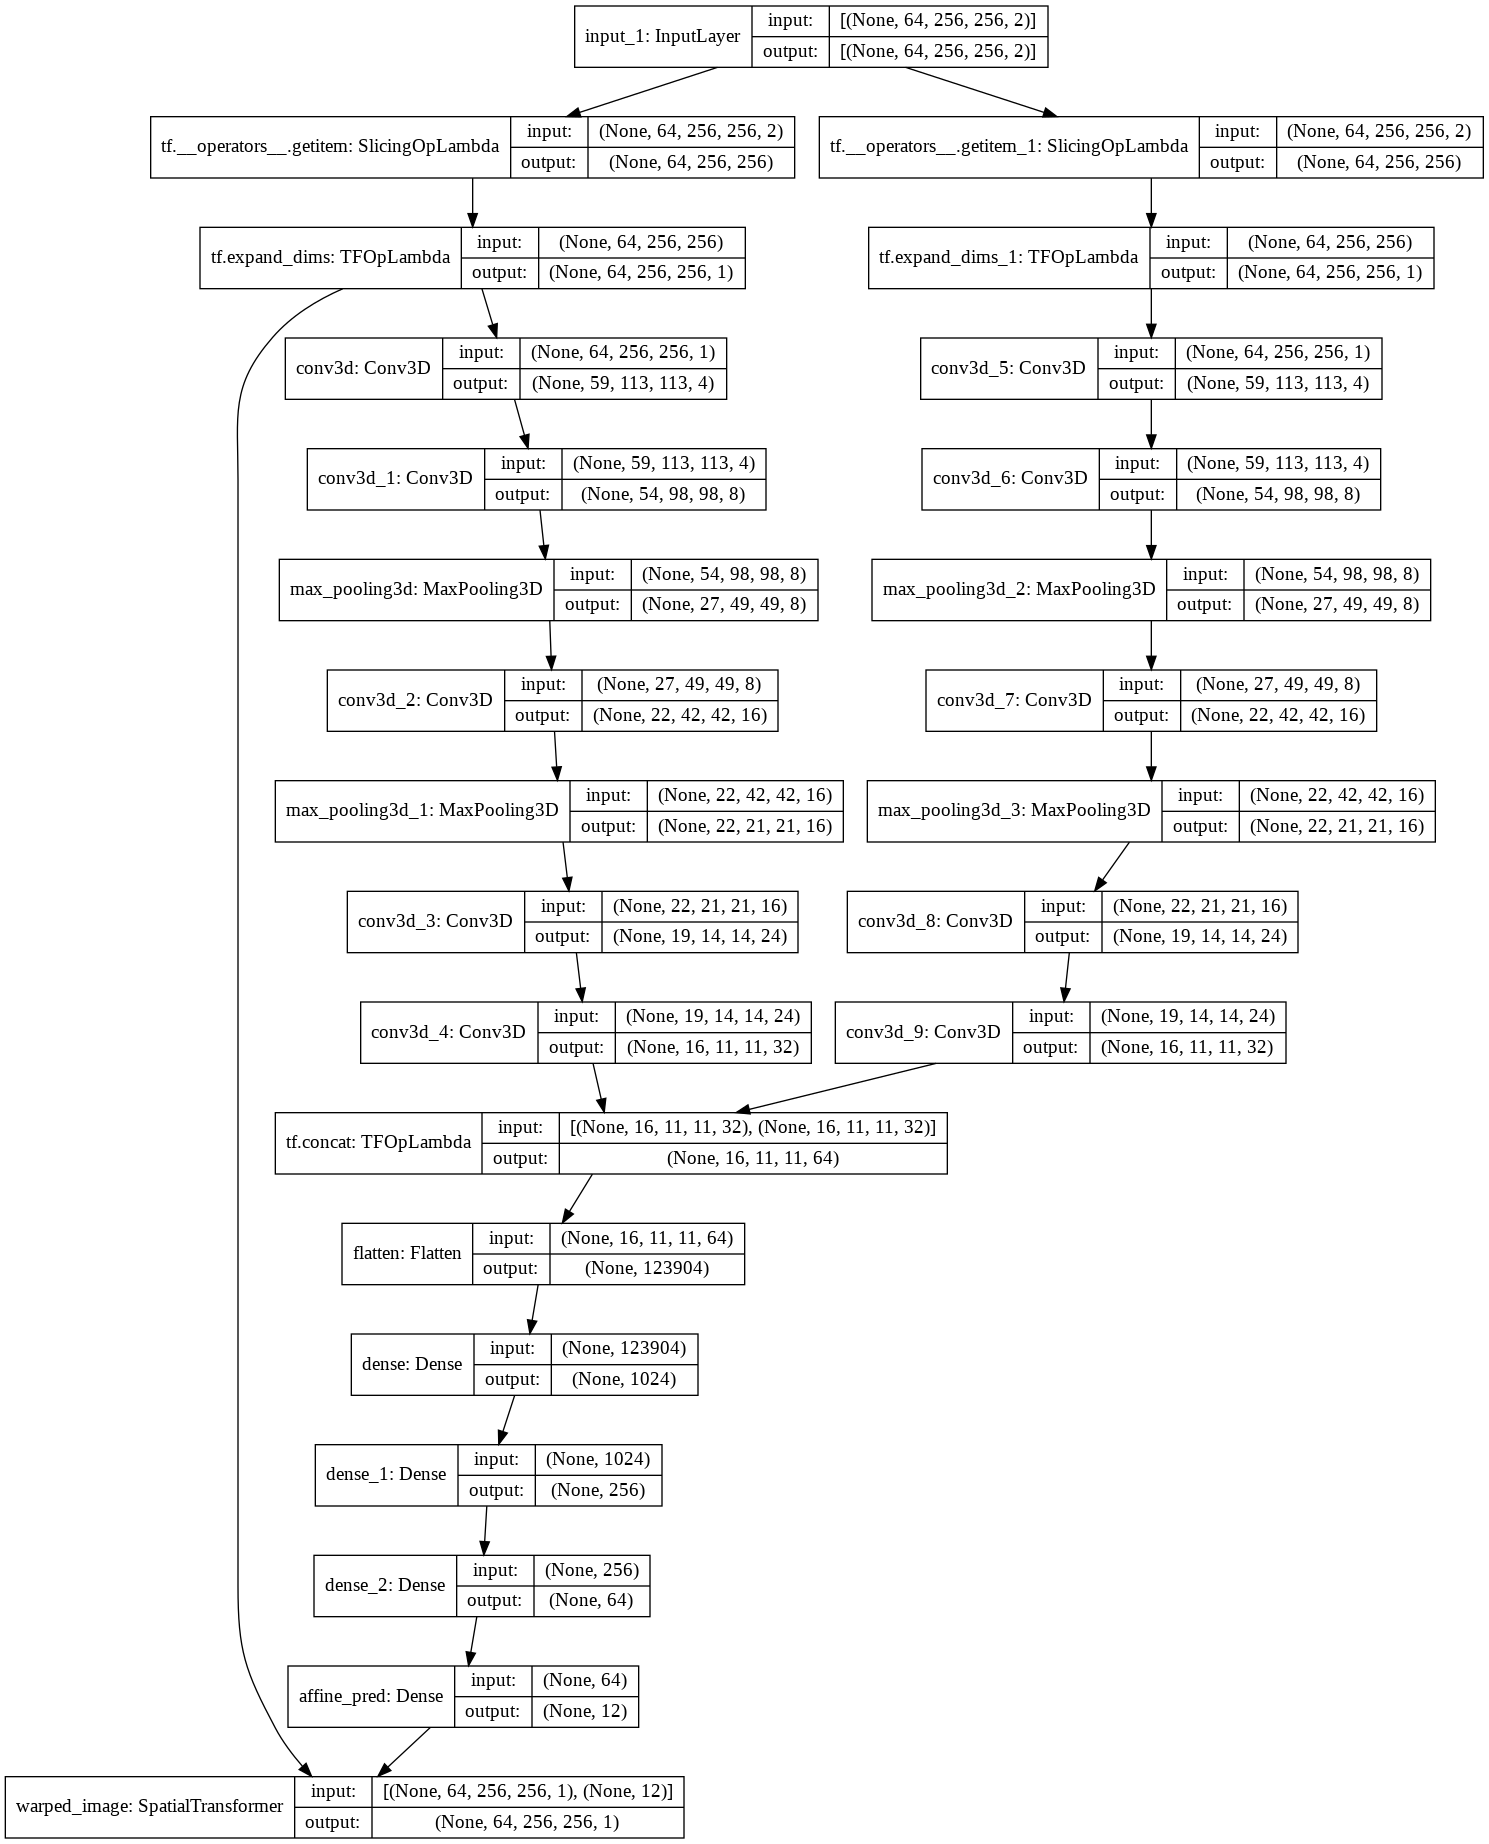

In [ ]:
keras.utils.plot_model(model, "test4.png", show_shapes=True)

#### New Baseline: direct affine matrix pred + DLIR style CNN

In [ ]:
## new baseline model
## 1. use lrelu for all relu
## 2. 5 layer of alternating 3x3x3 conv + 2/1x2x2 maxpool, the last pool is global average
##

# Change the channel dimension to get the image pair shape
# imgPairShape = list(fixedImg.shape)[1:]
imgPairShape = list(fixed_input_shape)[1:]
imgPairShape[-1] = 2
inputs = keras.Input(shape = imgPairShape)
# moving_input = tf.expand_dims(inputs[:, :, :, :, 0], axis = -1)
# fixed_input = tf.expand_dims(inputs[:, :, :, :, 1], axis = -1)
moving_input, fixed_input = inputs[..., 0:1], inputs[..., 1:2]

# down_depths = [4, 8, 16, 24, 32]
# up_depths = [2, 16, 32, 16, 3]
down_depths = [16, 32, 64, 256, 512]
lrelu = layers.LeakyReLU(alpha=0.1)

# pipeline1
conv_0 = layers.Conv3D(filters=down_depths[0], kernel_size=(3, 3, 3), 
                       padding='same', activation=lrelu)(moving_input)
print("conv_0: {}".format(conv_0.shape))
filtered_conv_0 = layers.MaxPool3D((2, 2, 2))(conv_0)

conv_1 = layers.Conv3D(filters=down_depths[1], kernel_size=(3, 3, 3), 
                       padding='same', activation=lrelu)(filtered_conv_0)
print("conv_1: {}".format(conv_1.shape))
filtered_conv_1 = layers.MaxPool3D((2, 2, 2))(conv_1)
print("filtered_conv_1: {}".format(filtered_conv_1.shape))

conv_2 = layers.Conv3D(filters=down_depths[2], kernel_size=(3, 3, 3), 
                       padding='same', activation=lrelu)(filtered_conv_1)
print("conv_2: {}".format(conv_2.shape))
filtered_conv_2 = layers.MaxPool3D((1, 2, 2))(conv_2)
print("filtered_conv_2: {}".format(filtered_conv_2.shape))

conv_3 = layers.Conv3D(filters=down_depths[3], kernel_size=(3, 3, 3), 
                       padding='same', activation=lrelu)(filtered_conv_2)
print("conv_3: {}".format(conv_3.shape))
filtered_conv_3 = layers.MaxPool3D((1, 2, 2))(conv_3)
print("conv_3: {}".format(conv_3.shape))

conv_4 = layers.Conv3D(filters=down_depths[4], kernel_size=(3, 3, 3), 
                       padding='valid', activation=lrelu)(filtered_conv_3)
print("conv_4: {}".format(conv_4.shape))
global_ave_4 = layers.GlobalAveragePooling3D()(conv_4)

# pipeline 2
f_conv_0 = layers.Conv3D(filters=down_depths[0], kernel_size=(3, 3, 3), 
                         padding='same', activation=lrelu)(fixed_input)
f_filtered_conv_0 = layers.MaxPool3D((2, 2, 2))(f_conv_0)
f_conv_1 = layers.Conv3D(filters=down_depths[1], kernel_size=(3, 3, 3), 
                         padding='same', activation=lrelu)(f_filtered_conv_0)
f_filtered_conv_1 = layers.MaxPool3D((2, 2, 2))(f_conv_1)
f_conv_2 = layers.Conv3D(filters=down_depths[2], kernel_size=(3, 3, 3), 
                         padding='same', activation=lrelu)(f_filtered_conv_1)
f_filtered_conv_2 = layers.MaxPool3D((2, 2, 2))(f_conv_2)
f_conv_3 = layers.Conv3D(filters=down_depths[3], kernel_size=(3, 3, 3), 
                         padding='same', activation=lrelu)(f_filtered_conv_2)
f_filtered_conv_3 = layers.MaxPool3D((1, 2, 2))(f_conv_3)
f_conv_4 = layers.Conv3D(filters=down_depths[4], kernel_size=(3, 3, 3), 
                         padding='valid', activation=lrelu)(f_filtered_conv_3)
f_global_ave_4 = layers.GlobalAveragePooling3D()(f_conv_4)

concat_feats = tf.concat([global_ave_4, f_global_ave_4], axis = -1) # [B, C]
print(concat_feats.shape)

dense_0 = layers.Dense(1024, activation=lrelu)(concat_feats)
dense_1 = layers.Dense(128, activation=lrelu)(dense_0)
# dense_1 = layers.Dense(256, activation=lrelu)(dense_0)
# dense_2 = layers.Dense(64, activation=lrelu)(dense_1)
affine_pred = layers.Dense(12, activation="linear", name="affine_pred")(dense_1)


# convTransposed_3 = layers.Conv3DTranspose(filters=up_depths[0], kernel_size=(6, 10, 10), activation="relu")(conv_4)
# print("convTransposed_3: {}".format(convTransposed_3.shape))
# filtered_convTransposed_2 = layers.Conv3DTranspose(filters=up_depths[1], kernel_size=(6, 20, 20), activation="relu")(convTransposed_3)
# print("filtered_convTransposed_2: {}".format(filtered_convTransposed_2.shape))
# convTransposed_2 = layers.UpSampling3D((1, 2, 2))(filtered_convTransposed_2)
# print("convTransposed_2: {}".format(convTransposed_2.shape))
# filtered_convTransposed_1 = layers.Conv3DTranspose(filters=up_depths[2], kernel_size=(3, 15, 15), activation="relu")(convTransposed_2)
# print("filtered_convTransposed_1: {}".format(filtered_convTransposed_1.shape))
# convTransposed_1 = layers.UpSampling3D((2, 2, 2))(filtered_convTransposed_1)
# print("convTransposed_1: {}".format(convTransposed_1.shape))
# convTransposed_0 = layers.Conv3DTranspose(filters=up_depths[3], kernel_size=(3, 16, 16), activation="relu")(convTransposed_1)
# print("convTransposed_0: {}".format(convTransposed_0.shape))
# deformation_field_pred = layers.Conv3DTranspose(filters=up_depths[4], kernel_size=(3, 10, 10), activation="relu")(convTransposed_0)
# print("deformation_field_pred: {}".format(deformation_field_pred.shape))

affine_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=True)([moving_input, affine_pred])
# deformable_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=False)([affine_warped, deformation_field_pred])
print(affine_warped.shape)

conv_0: (None, 64, 256, 256, 16)
conv_1: (None, 32, 128, 128, 32)
filtered_conv_1: (None, 16, 64, 64, 32)
conv_2: (None, 16, 64, 64, 64)
filtered_conv_2: (None, 16, 32, 32, 64)
conv_3: (None, 16, 32, 32, 256)
conv_3: (None, 16, 32, 32, 256)
conv_4: (None, 14, 14, 14, 512)
(None, 1024)
(None, 64, 256, 256, 1)


In [ ]:
model = keras.Model(inputs=inputs, outputs=[affine_warped, affine_pred], name="baseline_model")
model.summary(line_length=150)

Model: "baseline_model"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_1 (InputLayer)                             [(None, 64, 256, 256, 2)]        0                                                                   
______________________________________________________________________________________________________________________________________________________
tf.__operators__.getitem (SlicingOpLambda)       (None, 64, 256, 256, 1)          0                 input_1[0][0]                                     
______________________________________________________________________________________________________________________________________________________
tf.__operators__.getitem_1 (SlicingOpLambda)     (None, 64, 256, 256, 

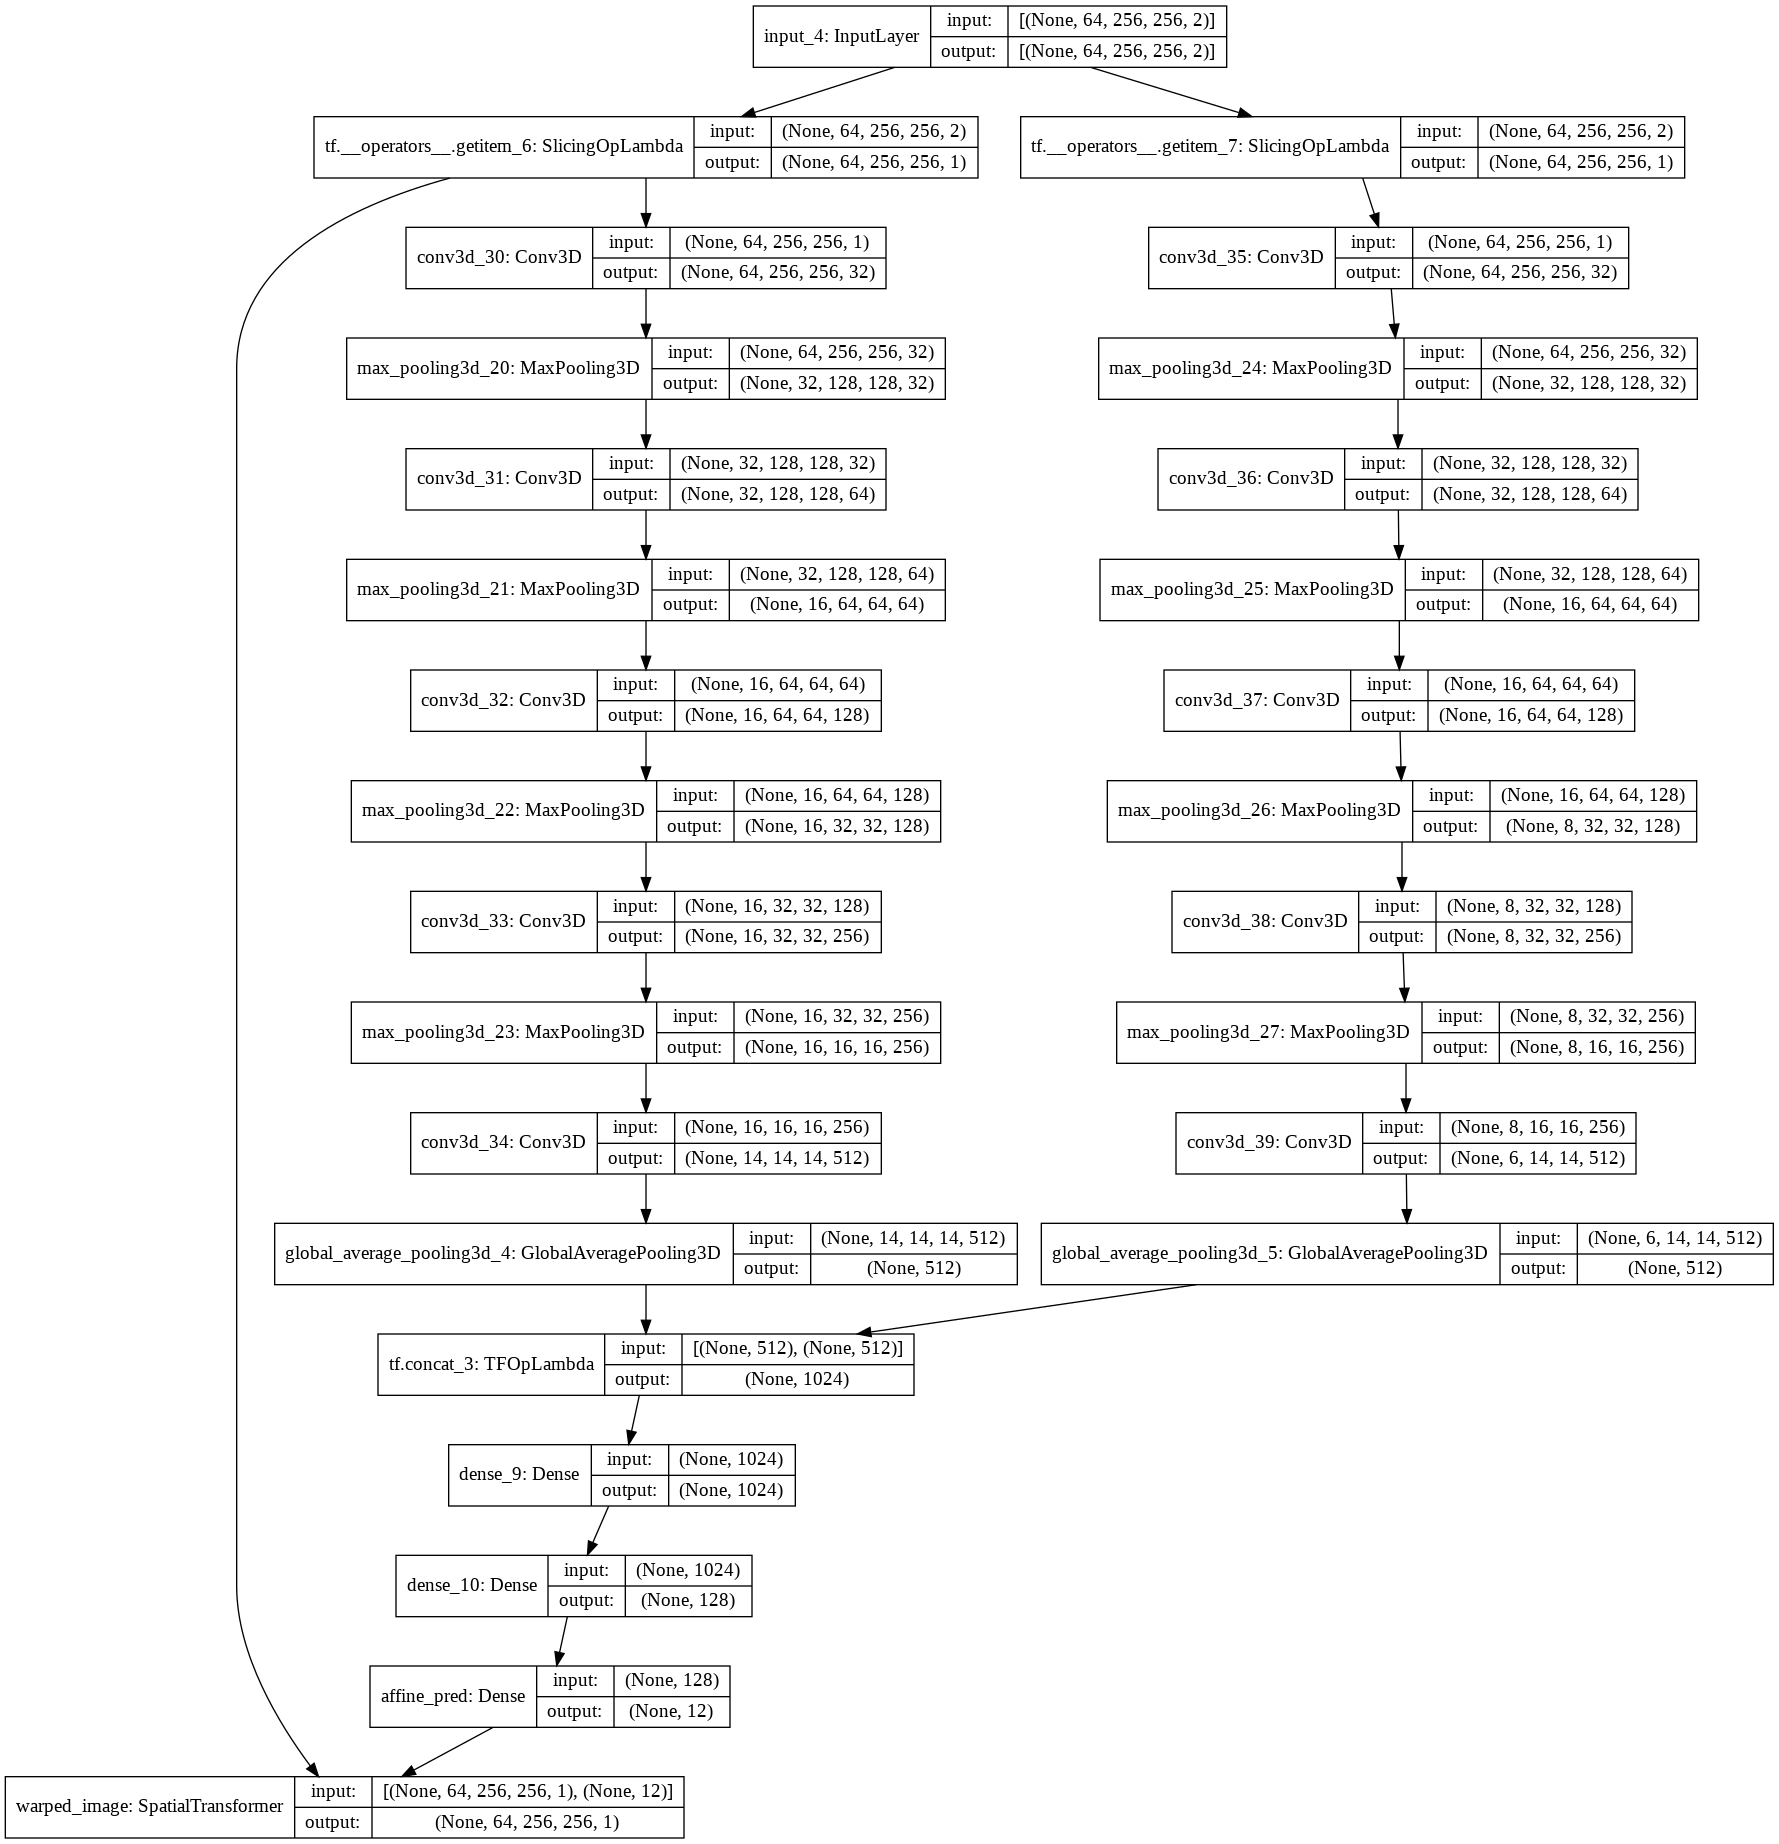

In [ ]:
keras.utils.plot_model(model, "baseline_DLIR.png", show_shapes=True)

In [ ]:
## new baseline model
## 1. use lrelu for all relu
## 2. 5 layer of alternating 3x3x3 conv + 2/1x2x2 maxpool, the last pool is global average
##

# Change the channel dimension to get the image pair shape
# imgPairShape = list(fixedImg.shape)[1:]
imgPairShape = list(fixed_input_shape)[1:]
imgPairShape[-1] = 2
inputs = keras.Input(shape = imgPairShape)
# moving_input = tf.expand_dims(inputs[:, :, :, :, 0], axis = -1)
# fixed_input = tf.expand_dims(inputs[:, :, :, :, 1], axis = -1)
moving_input, fixed_input = inputs[..., 0:1], inputs[..., 1:2]

# down_depths = [4, 8, 16, 24, 32]
# up_depths = [2, 16, 32, 16, 3]
# down_depths = [16, 32, 64, 256, 512]# v1
# down_depths = [32, 64, 128, 512, 1024]
down_depths = [16, 32, 128, 512, 512]
lrelu = layers.LeakyReLU(alpha=0.1)

# pipeline1
conv_0 = layers.Conv3D(filters=down_depths[0], kernel_size=(3, 3, 3), 
                       padding='same', activation=lrelu)(moving_input)
print("conv_0: {}".format(conv_0.shape))
filtered_conv_0 = layers.MaxPool3D((2, 2, 2))(conv_0)

conv_1 = layers.Conv3D(filters=down_depths[1], kernel_size=(3, 3, 3), 
                       padding='same', activation=lrelu)(filtered_conv_0)
print("conv_1: {}".format(conv_1.shape))
filtered_conv_1 = layers.MaxPool3D((2, 2, 2))(conv_1)
print("filtered_conv_1: {}".format(filtered_conv_1.shape))

conv_2 = layers.Conv3D(filters=down_depths[2], kernel_size=(3, 3, 3), 
                       padding='same', activation=lrelu)(filtered_conv_1)
print("conv_2: {}".format(conv_2.shape))
filtered_conv_2 = layers.MaxPool3D((1, 2, 2))(conv_2)
print("filtered_conv_2: {}".format(filtered_conv_2.shape))

conv_3 = layers.Conv3D(filters=down_depths[3], kernel_size=(3, 3, 3), 
                       padding='same', activation=lrelu)(filtered_conv_2)
print("conv_3: {}".format(conv_3.shape))
filtered_conv_3 = layers.MaxPool3D((1, 2, 2))(conv_3)
print("conv_3: {}".format(conv_3.shape))

conv_4 = layers.Conv3D(filters=down_depths[4], kernel_size=(3, 3, 3), 
                       padding='valid', activation=lrelu)(filtered_conv_3)
print("conv_4: {}".format(conv_4.shape))
global_ave_4 = layers.GlobalAveragePooling3D()(conv_4)

# pipeline 2
f_conv_0 = layers.Conv3D(filters=down_depths[0], kernel_size=(3, 3, 3), 
                         padding='same', activation=lrelu)(fixed_input)
f_filtered_conv_0 = layers.MaxPool3D((2, 2, 2))(f_conv_0)
f_conv_1 = layers.Conv3D(filters=down_depths[1], kernel_size=(3, 3, 3), 
                         padding='same', activation=lrelu)(f_filtered_conv_0)
f_filtered_conv_1 = layers.MaxPool3D((2, 2, 2))(f_conv_1)
f_conv_2 = layers.Conv3D(filters=down_depths[2], kernel_size=(3, 3, 3), 
                         padding='same', activation=lrelu)(f_filtered_conv_1)
f_filtered_conv_2 = layers.MaxPool3D((2, 2, 2))(f_conv_2)
f_conv_3 = layers.Conv3D(filters=down_depths[3], kernel_size=(3, 3, 3), 
                         padding='same', activation=lrelu)(f_filtered_conv_2)
f_filtered_conv_3 = layers.MaxPool3D((1, 2, 2))(f_conv_3)
f_conv_4 = layers.Conv3D(filters=down_depths[4], kernel_size=(3, 3, 3), 
                         padding='valid', activation=lrelu)(f_filtered_conv_3)
f_global_ave_4 = layers.GlobalAveragePooling3D()(f_conv_4)

concat_feats = tf.concat([global_ave_4, f_global_ave_4], axis = -1) # [B, C]
print(concat_feats.shape)

dense_0 = layers.Dense(1024, activation=lrelu)(concat_feats)
dense_1 = layers.Dense(256, activation=lrelu)(dense_0)
dense_2 = layers.Dense(64, activation=lrelu)(dense_1)
affine_pred = layers.Dense(12, activation="linear", name="affine_pred")(dense_2)


# convTransposed_3 = layers.Conv3DTranspose(filters=up_depths[0], kernel_size=(6, 10, 10), activation="relu")(conv_4)
# print("convTransposed_3: {}".format(convTransposed_3.shape))
# filtered_convTransposed_2 = layers.Conv3DTranspose(filters=up_depths[1], kernel_size=(6, 20, 20), activation="relu")(convTransposed_3)
# print("filtered_convTransposed_2: {}".format(filtered_convTransposed_2.shape))
# convTransposed_2 = layers.UpSampling3D((1, 2, 2))(filtered_convTransposed_2)
# print("convTransposed_2: {}".format(convTransposed_2.shape))
# filtered_convTransposed_1 = layers.Conv3DTranspose(filters=up_depths[2], kernel_size=(3, 15, 15), activation="relu")(convTransposed_2)
# print("filtered_convTransposed_1: {}".format(filtered_convTransposed_1.shape))
# convTransposed_1 = layers.UpSampling3D((2, 2, 2))(filtered_convTransposed_1)
# print("convTransposed_1: {}".format(convTransposed_1.shape))
# convTransposed_0 = layers.Conv3DTranspose(filters=up_depths[3], kernel_size=(3, 16, 16), activation="relu")(convTransposed_1)
# print("convTransposed_0: {}".format(convTransposed_0.shape))
# deformation_field_pred = layers.Conv3DTranspose(filters=up_depths[4], kernel_size=(3, 10, 10), activation="relu")(convTransposed_0)
# print("deformation_field_pred: {}".format(deformation_field_pred.shape))

affine_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=True)([moving_input, affine_pred])
# deformable_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=False)([affine_warped, deformation_field_pred])
print(affine_warped.shape)

model = keras.Model(inputs=inputs, outputs=[affine_warped, affine_pred], name="baseline_model")
model.summary(line_length=150)

conv_0: (None, 64, 256, 256, 16)
conv_1: (None, 32, 128, 128, 32)
filtered_conv_1: (None, 16, 64, 64, 32)
conv_2: (None, 16, 64, 64, 128)
filtered_conv_2: (None, 16, 32, 32, 128)
conv_3: (None, 16, 32, 32, 512)
conv_3: (None, 16, 32, 32, 512)
conv_4: (None, 14, 14, 14, 512)
(None, 1024)
(None, 64, 256, 256, 1)
Model: "baseline_model"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_12 (InputLayer)                            [(None, 64, 256, 256, 2)]        0                                                                   
______________________________________________________________________________________________________________________________________________________
tf.__operators__.getitem_20 (SlicingOpLambda)    (None, 64, 

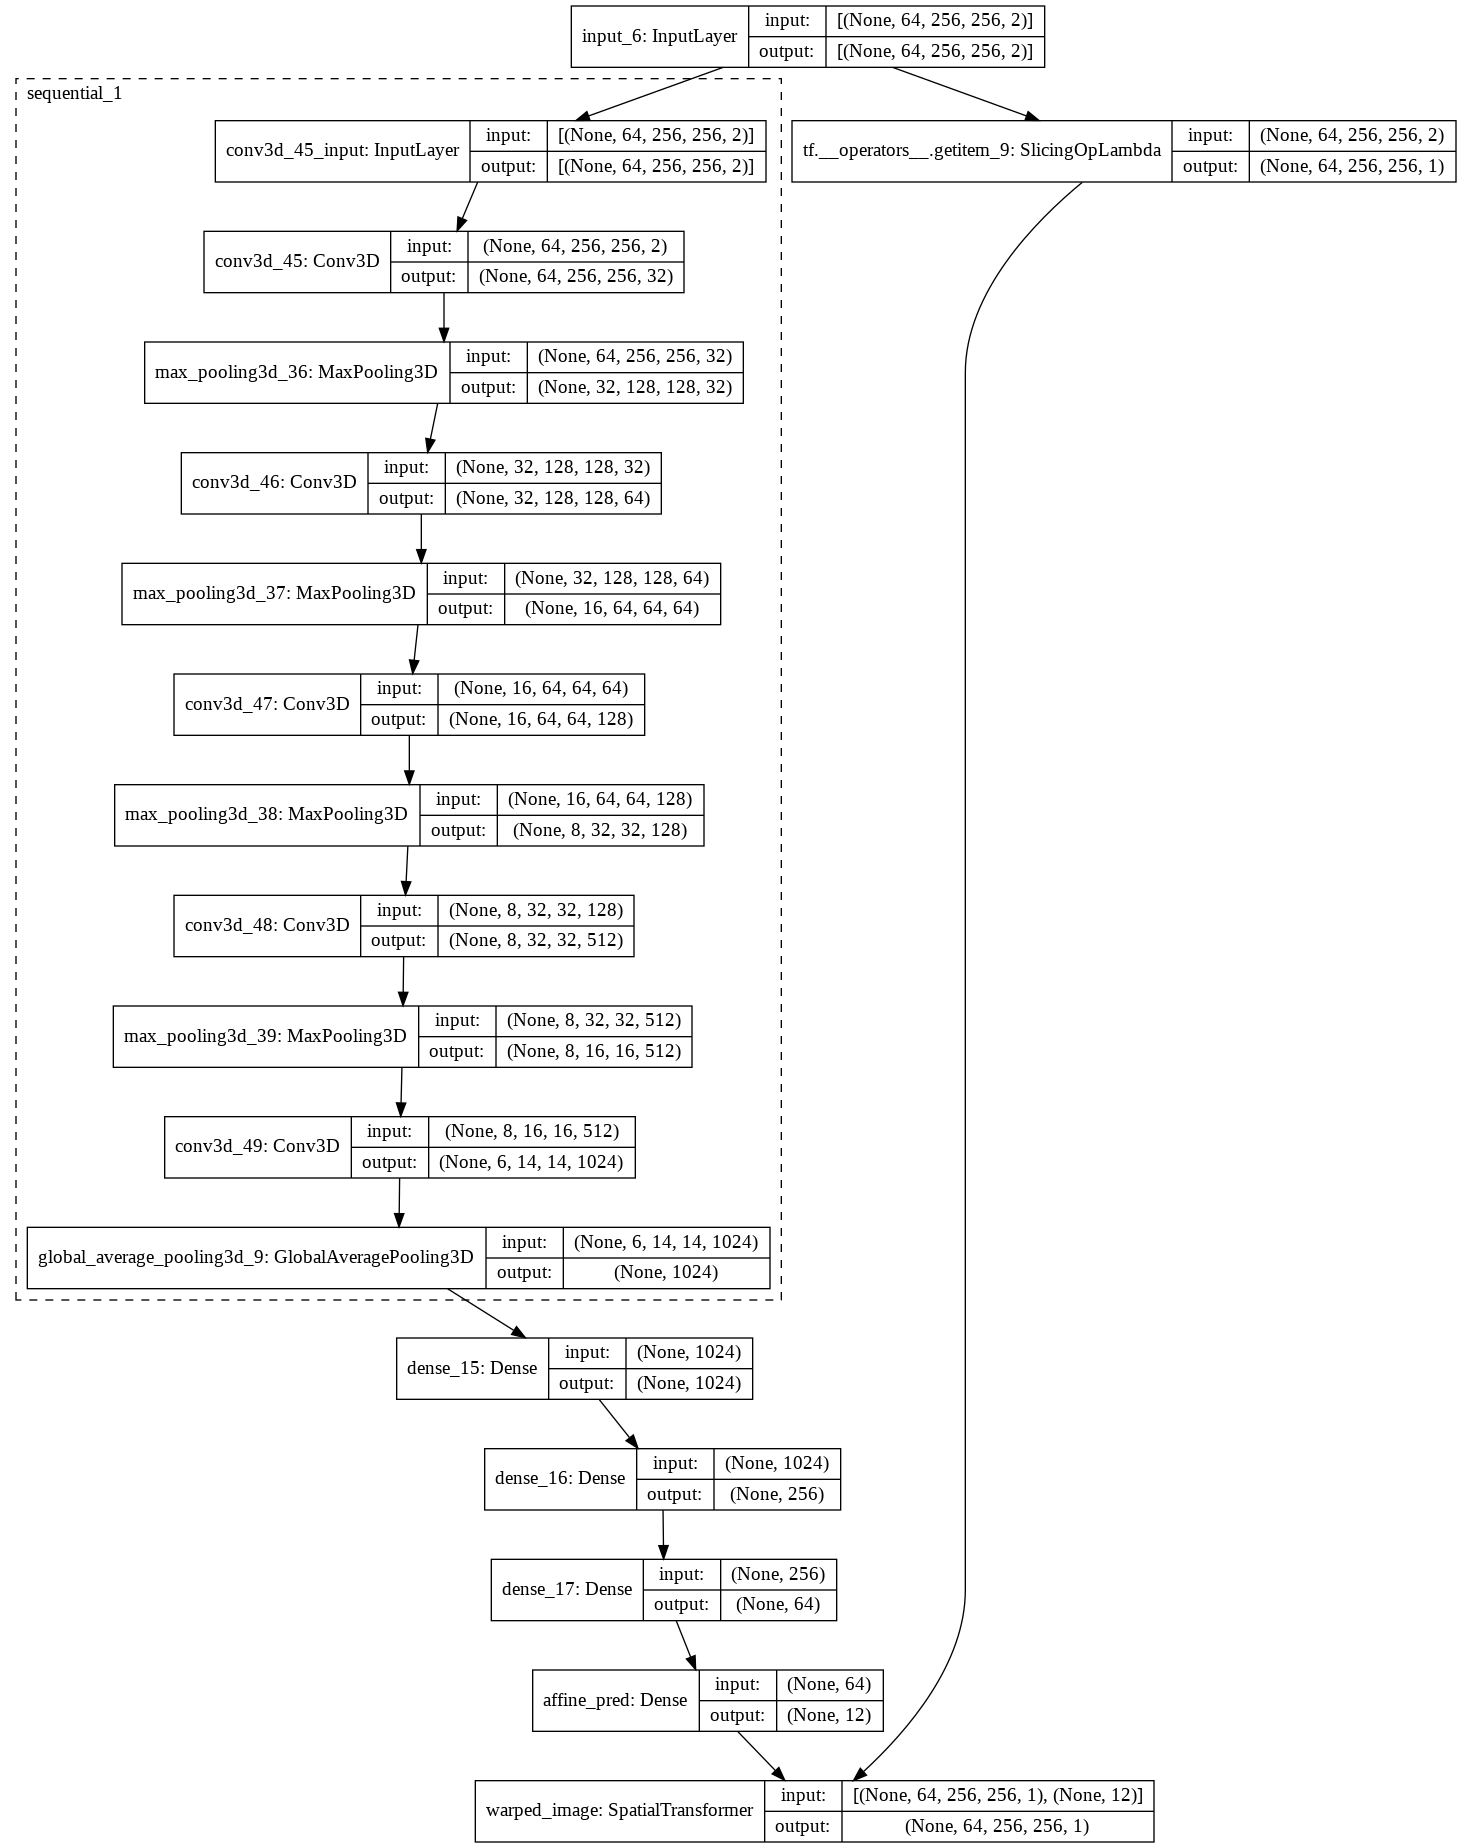

In [ ]:
keras.utils.plot_model(model, "baseline_DLIR_v2.png", show_shapes=True, expand_nested=True)

#### DLIR 2: one pipeline for concatenated input

In [ ]:
## DLIR
## 1. use lrelu for all relu
## 2. 5 layer of alternating 3x3x3 conv + 2/1x2x2 maxpool, the last pool is global average
## 3. two pipelines share weights

# Change the channel dimension to get the image pair shape
imgPairShape = list(fixed_input_shape)[1:]
imgPairShape[-1] = 2
inputs = keras.Input(shape = imgPairShape)
print(inputs.shape)

moving_input = inputs[..., 0:1]
# fixed_input = inputs[..., 1:2]

# down_depths = [4, 8, 16, 24, 32]
# up_depths = [2, 16, 32, 16, 3]
down_depths = [32, 64, 128, 512, 1024]
lrelu = layers.LeakyReLU(alpha=0.1)

# two pipelines share the weights:
pipeline = keras.Sequential([
    layers.Conv3D(filters=down_depths[0], kernel_size=(3, 3, 3), padding='same', activation=lrelu),
    layers.MaxPool3D((2, 2, 2)),
    layers.Conv3D(filters=down_depths[1], kernel_size=(3, 3, 3), padding='same', activation=lrelu),
    layers.MaxPool3D((2, 2, 2)),
    layers.Conv3D(filters=down_depths[2], kernel_size=(3, 3, 3), padding='same', activation=lrelu),
    layers.MaxPool3D((1, 2, 2)),
    layers.Conv3D(filters=down_depths[3], kernel_size=(3, 3, 3), padding='same', activation=lrelu),
    layers.MaxPool3D((1, 2, 2)),
    layers.Conv3D(filters=down_depths[4], kernel_size=(3, 3, 3), padding='valid', activation=lrelu),
    layers.GlobalAveragePooling3D(), # [B, C]
])
# global_ave_4 = pipeline(moving_input)
# f_global_ave_4 = pipeline(fixed_input)
# concat_feats = tf.concat([global_ave_4, f_global_ave_4], axis = -1) # [B, C]

concat_feats = pipeline(inputs)
print(concat_feats.shape)

dense_0 = layers.Dense(1024, activation=lrelu)(concat_feats)
dense_1 = layers.Dense(128, activation=lrelu)(dense_0)
affine_pred = layers.Dense(12, activation="linear", name="affine_pred")(dense_1)


# convTransposed_3 = layers.Conv3DTranspose(filters=up_depths[0], kernel_size=(6, 10, 10), activation="relu")(conv_4)
# print("convTransposed_3: {}".format(convTransposed_3.shape))
# filtered_convTransposed_2 = layers.Conv3DTranspose(filters=up_depths[1], kernel_size=(6, 20, 20), activation="relu")(convTransposed_3)
# print("filtered_convTransposed_2: {}".format(filtered_convTransposed_2.shape))
# convTransposed_2 = layers.UpSampling3D((1, 2, 2))(filtered_convTransposed_2)
# print("convTransposed_2: {}".format(convTransposed_2.shape))
# filtered_convTransposed_1 = layers.Conv3DTranspose(filters=up_depths[2], kernel_size=(3, 15, 15), activation="relu")(convTransposed_2)
# print("filtered_convTransposed_1: {}".format(filtered_convTransposed_1.shape))
# convTransposed_1 = layers.UpSampling3D((2, 2, 2))(filtered_convTransposed_1)
# print("convTransposed_1: {}".format(convTransposed_1.shape))
# convTransposed_0 = layers.Conv3DTranspose(filters=up_depths[3], kernel_size=(3, 16, 16), activation="relu")(convTransposed_1)
# print("convTransposed_0: {}".format(convTransposed_0.shape))
# deformation_field_pred = layers.Conv3DTranspose(filters=up_depths[4], kernel_size=(3, 10, 10), activation="relu")(convTransposed_0)
# print("deformation_field_pred: {}".format(deformation_field_pred.shape))

affine_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=True)([moving_input, affine_pred])
# deformable_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=False)([affine_warped, deformation_field_pred])
print(affine_warped.shape)

(None, 64, 256, 256, 2)
(None, 1024)
(None, 64, 256, 256, 1)


In [ ]:
model = keras.Model(inputs=inputs, outputs=[affine_warped, affine_pred], name="baseline_model")
model.summary(line_length=150)

Model: "baseline_model"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_1 (InputLayer)                             [(None, 64, 256, 256, 2)]        0                                                                   
______________________________________________________________________________________________________________________________________________________
sequential (Sequential)                          (None, 1024)                     16205216          input_1[0][0]                                     
______________________________________________________________________________________________________________________________________________________
dense (Dense)                                    (None, 1024)         

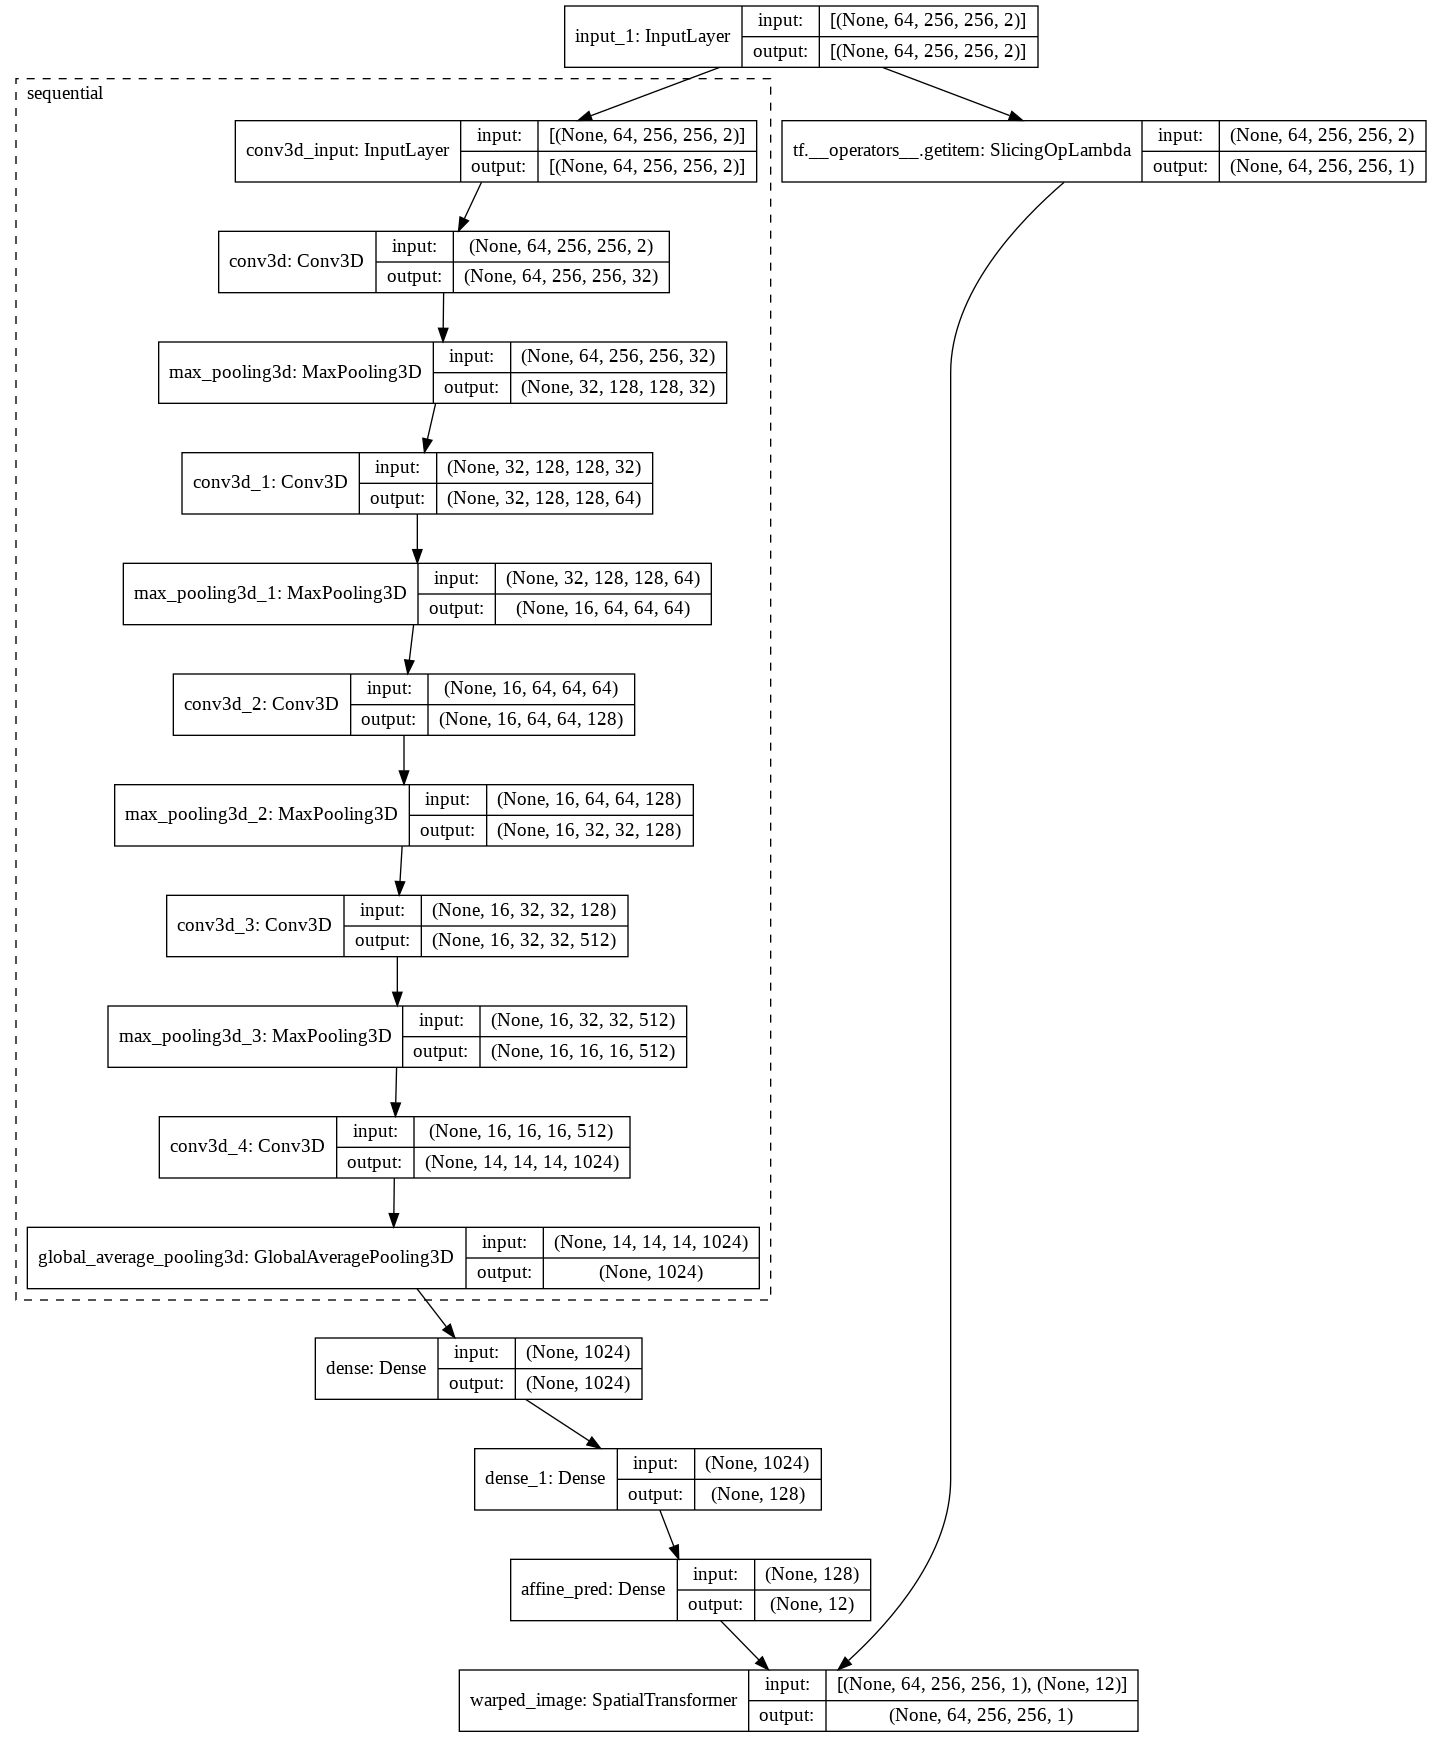

In [ ]:
keras.utils.plot_model(model, "./model_img/DLIR_2.png", show_shapes=True, expand_nested=True)

In [ ]:
## DLIR
## 1. use lrelu for all relu
## 2. 5 layer of alternating 3x3x3 conv + 2/1x2x2 maxpool, the last pool is global average
## 3. two pipelines share weights

# Change the channel dimension to get the image pair shape
imgPairShape = list(fixed_input_shape)[1:]
imgPairShape[-1] = 2
inputs = keras.Input(shape = imgPairShape)
print(inputs.shape)

moving_input = inputs[..., 0:1]
# fixed_input = inputs[..., 1:2]

# down_depths = [4, 8, 16, 24, 32]
# up_depths = [2, 16, 32, 16, 3]
down_depths = [32, 64, 128, 512, 1024]
lrelu = layers.LeakyReLU(alpha=0.1)

# two pipelines share the weights:
pipeline = keras.Sequential([
    layers.Conv3D(filters=down_depths[0], kernel_size=(3, 3, 3), padding='same', activation=lrelu),
    layers.MaxPool3D((2, 2, 2)),
    layers.Conv3D(filters=down_depths[1], kernel_size=(3, 3, 3), padding='same', activation=lrelu),
    layers.MaxPool3D((2, 2, 2)),
    layers.Conv3D(filters=down_depths[2], kernel_size=(3, 3, 3), padding='same', activation=lrelu),
    layers.MaxPool3D((2, 2, 2)),
    layers.Conv3D(filters=down_depths[3], kernel_size=(3, 3, 3), padding='same', activation=lrelu),
    layers.MaxPool3D((1, 2, 2)),
    layers.Conv3D(filters=down_depths[4], kernel_size=(3, 3, 3), padding='valid', activation=lrelu),
    layers.GlobalAveragePooling3D(), # [B, C]
])
# global_ave_4 = pipeline(moving_input)
# f_global_ave_4 = pipeline(fixed_input)
# concat_feats = tf.concat([global_ave_4, f_global_ave_4], axis = -1) # [B, C]

concat_feats = pipeline(inputs)
print(concat_feats.shape)

dense_0 = layers.Dense(1024, activation=lrelu)(concat_feats)
dense_1 = layers.Dense(256, activation=lrelu)(dense_0)
dense_2 = layers.Dense(64, activation=lrelu)(dense_1)
affine_pred = layers.Dense(12, activation="linear", name="affine_pred")(dense_2)


# convTransposed_3 = layers.Conv3DTranspose(filters=up_depths[0], kernel_size=(6, 10, 10), activation="relu")(conv_4)
# print("convTransposed_3: {}".format(convTransposed_3.shape))
# filtered_convTransposed_2 = layers.Conv3DTranspose(filters=up_depths[1], kernel_size=(6, 20, 20), activation="relu")(convTransposed_3)
# print("filtered_convTransposed_2: {}".format(filtered_convTransposed_2.shape))
# convTransposed_2 = layers.UpSampling3D((1, 2, 2))(filtered_convTransposed_2)
# print("convTransposed_2: {}".format(convTransposed_2.shape))
# filtered_convTransposed_1 = layers.Conv3DTranspose(filters=up_depths[2], kernel_size=(3, 15, 15), activation="relu")(convTransposed_2)
# print("filtered_convTransposed_1: {}".format(filtered_convTransposed_1.shape))
# convTransposed_1 = layers.UpSampling3D((2, 2, 2))(filtered_convTransposed_1)
# print("convTransposed_1: {}".format(convTransposed_1.shape))
# convTransposed_0 = layers.Conv3DTranspose(filters=up_depths[3], kernel_size=(3, 16, 16), activation="relu")(convTransposed_1)
# print("convTransposed_0: {}".format(convTransposed_0.shape))
# deformation_field_pred = layers.Conv3DTranspose(filters=up_depths[4], kernel_size=(3, 10, 10), activation="relu")(convTransposed_0)
# print("deformation_field_pred: {}".format(deformation_field_pred.shape))

affine_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=True)([moving_input, affine_pred])
# deformable_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=False)([affine_warped, deformation_field_pred])
print(affine_warped.shape)

model = keras.Model(inputs=inputs, outputs=[affine_warped, affine_pred], name="baseline_model")
model.summary(line_length=150)

(None, 64, 256, 256, 2)
(None, 1024)
(None, 64, 256, 256, 1)
Model: "baseline_model"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_6 (InputLayer)                             [(None, 64, 256, 256, 2)]        0                                                                   
______________________________________________________________________________________________________________________________________________________
sequential_1 (Sequential)                        (None, 1024)                     16205216          input_6[0][0]                                     
______________________________________________________________________________________________________________________________________________________
dense_15 

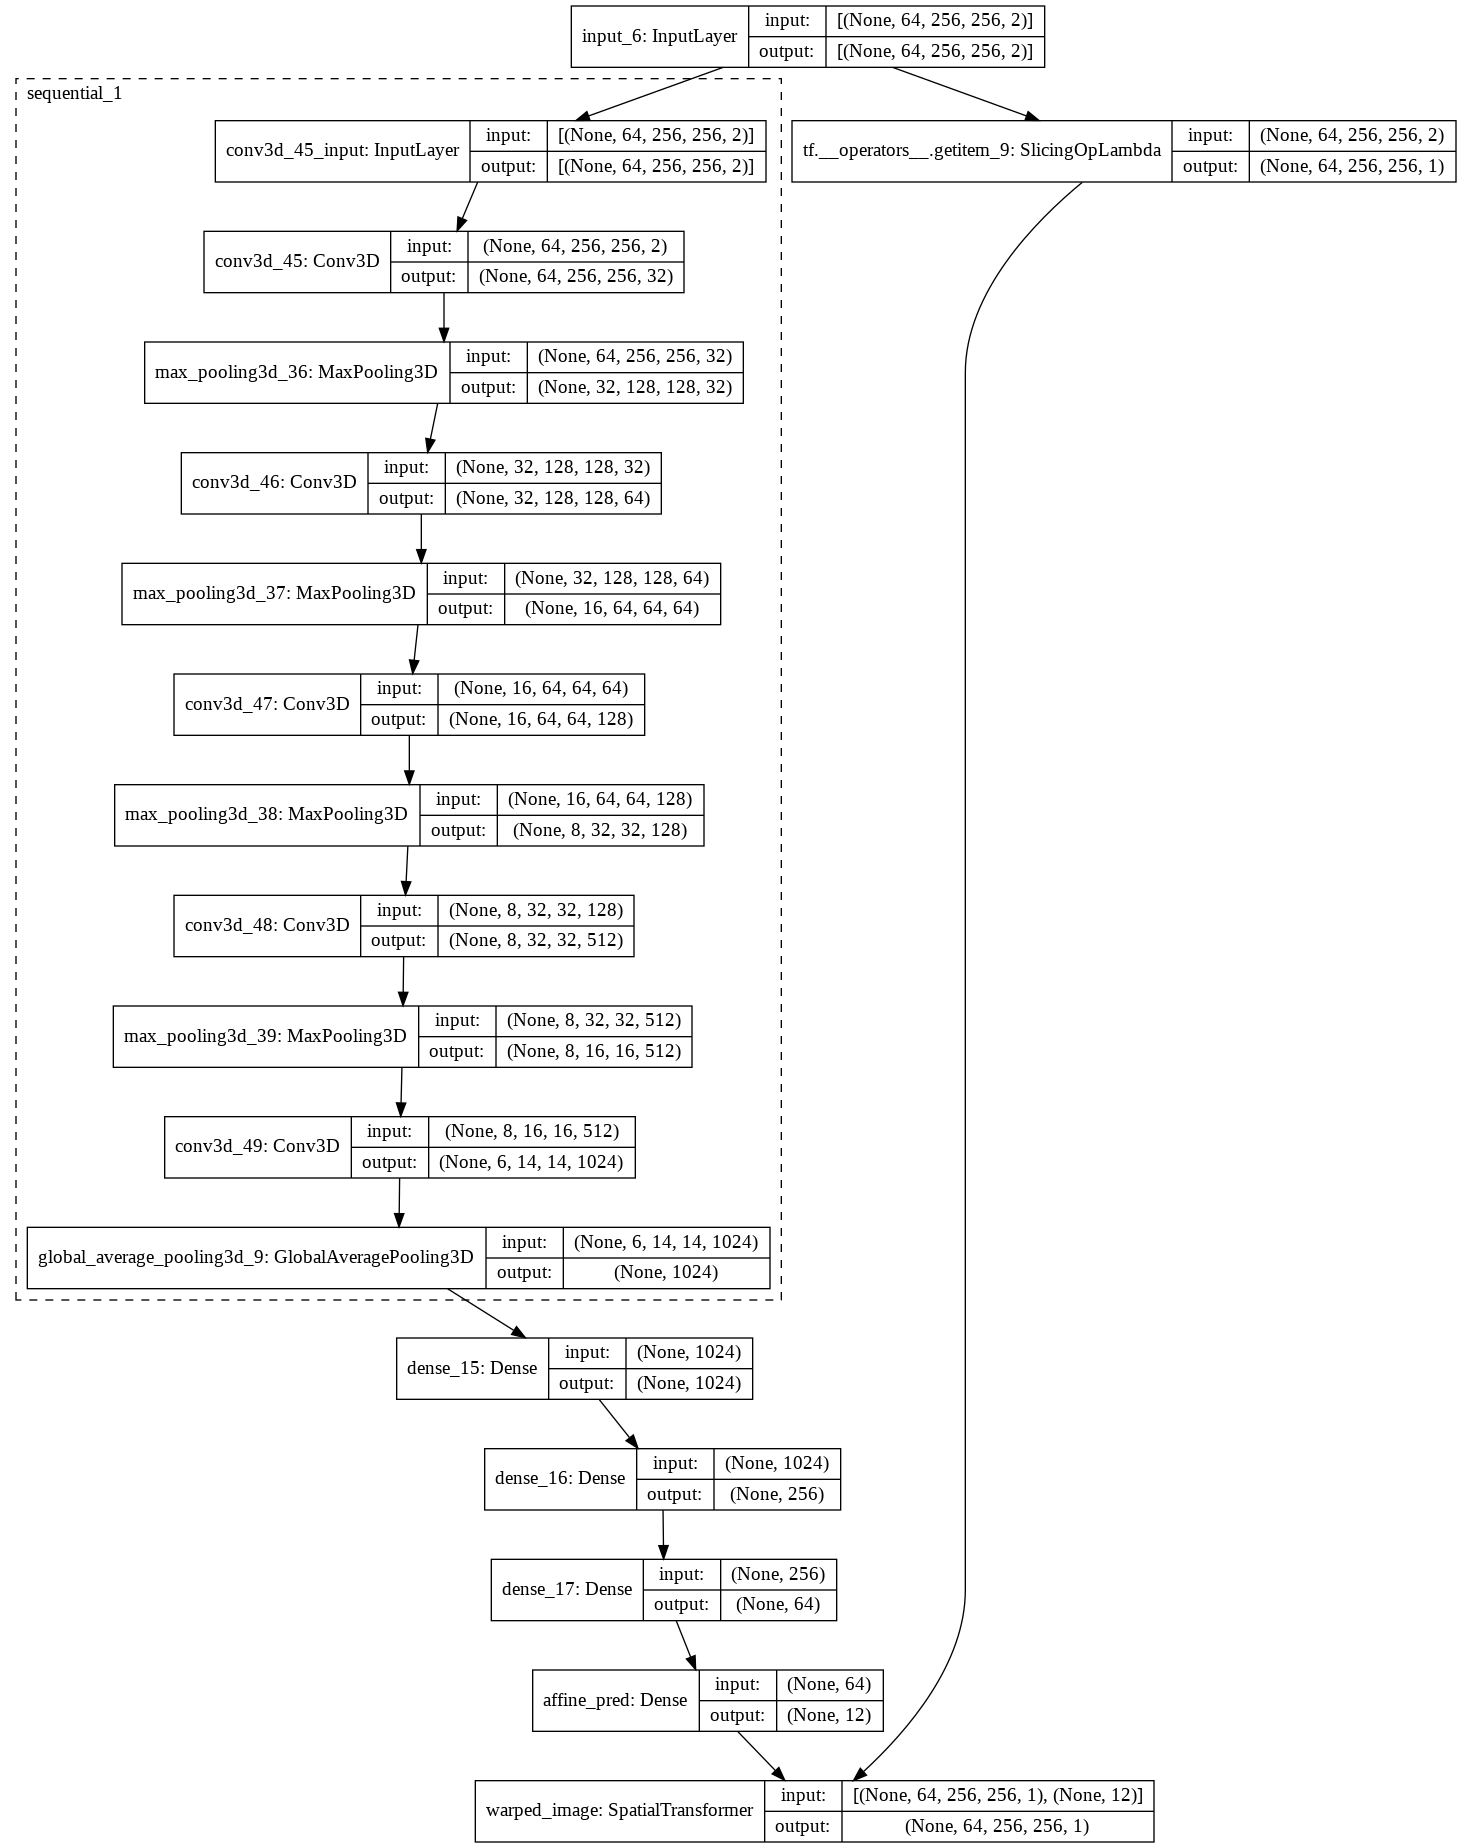

In [ ]:
keras.utils.plot_model(model, "./model_img/DLIR_2_v2.png", show_shapes=True, expand_nested=True)

#### DLIR: one pipeline for inputs separately

In [ ]:
## DLIR
## 1. use lrelu for all relu
## 2. 5 layer of alternating 3x3x3 conv + 2/1x2x2 maxpool, the last pool is global average
## 3. two pipelines share weights

# Change the channel dimension to get the image pair shape
imgPairShape = list(fixed_input_shape)[1:]
imgPairShape[-1] = 2
inputs = keras.Input(shape = imgPairShape)
print(inputs.shape)

moving_input = inputs[..., 0:1]
fixed_input = inputs[..., 1:2]

# down_depths = [4, 8, 16, 24, 32]
# up_depths = [2, 16, 32, 16, 3]
down_depths = [16, 64, 128, 512, 1024]
lrelu = layers.LeakyReLU(alpha=0.1)

# two pipelines share the weights:
pipeline = keras.Sequential([
    layers.Conv3D(filters=down_depths[0], kernel_size=(3, 3, 3), padding='same', activation=lrelu),
    layers.MaxPool3D((2, 2, 2)),
    layers.Conv3D(filters=down_depths[1], kernel_size=(3, 3, 3), padding='same', activation=lrelu),
    layers.MaxPool3D((2, 2, 2)),
    layers.Conv3D(filters=down_depths[2], kernel_size=(3, 3, 3), padding='same', activation=lrelu),
    layers.MaxPool3D((1, 2, 2)),
    layers.Conv3D(filters=down_depths[3], kernel_size=(3, 3, 3), padding='same', activation=lrelu),
    layers.MaxPool3D((1, 2, 2)),
    layers.Conv3D(filters=down_depths[4], kernel_size=(3, 3, 3), padding='valid', activation=lrelu),
    layers.GlobalAveragePooling3D(), # [B, C]
])
global_ave_4 = pipeline(moving_input)
f_global_ave_4 = pipeline(fixed_input)
concat_feats = tf.concat([global_ave_4, f_global_ave_4], axis = -1) # [B, C]
print(concat_feats.shape)

dense_0 = layers.Dense(1024, activation=lrelu)(concat_feats)
dense_1 = layers.Dense(128, activation=lrelu)(dense_0)
affine_pred = layers.Dense(12, activation="linear", name="affine_pred")(dense_1)


# convTransposed_3 = layers.Conv3DTranspose(filters=up_depths[0], kernel_size=(6, 10, 10), activation="relu")(conv_4)
# print("convTransposed_3: {}".format(convTransposed_3.shape))
# filtered_convTransposed_2 = layers.Conv3DTranspose(filters=up_depths[1], kernel_size=(6, 20, 20), activation="relu")(convTransposed_3)
# print("filtered_convTransposed_2: {}".format(filtered_convTransposed_2.shape))
# convTransposed_2 = layers.UpSampling3D((1, 2, 2))(filtered_convTransposed_2)
# print("convTransposed_2: {}".format(convTransposed_2.shape))
# filtered_convTransposed_1 = layers.Conv3DTranspose(filters=up_depths[2], kernel_size=(3, 15, 15), activation="relu")(convTransposed_2)
# print("filtered_convTransposed_1: {}".format(filtered_convTransposed_1.shape))
# convTransposed_1 = layers.UpSampling3D((2, 2, 2))(filtered_convTransposed_1)
# print("convTransposed_1: {}".format(convTransposed_1.shape))
# convTransposed_0 = layers.Conv3DTranspose(filters=up_depths[3], kernel_size=(3, 16, 16), activation="relu")(convTransposed_1)
# print("convTransposed_0: {}".format(convTransposed_0.shape))
# deformation_field_pred = layers.Conv3DTranspose(filters=up_depths[4], kernel_size=(3, 10, 10), activation="relu")(convTransposed_0)
# print("deformation_field_pred: {}".format(deformation_field_pred.shape))

affine_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=True)([moving_input, affine_pred])
# deformable_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=False)([affine_warped, deformation_field_pred])
print(affine_warped.shape)

(None, 64, 256, 256, 2)
(None, 2048)
(None, 64, 256, 256, 1)


In [ ]:
model = keras.Model(inputs=inputs, outputs=[affine_warped, affine_pred], name="baseline_model")
model.summary(line_length=150)

Model: "baseline_model"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_6 (InputLayer)                             [(None, 64, 256, 256, 2)]        0                                                                   
______________________________________________________________________________________________________________________________________________________
tf.__operators__.getitem_10 (SlicingOpLambda)    (None, 64, 256, 256, 1)          0                 input_6[0][0]                                     
______________________________________________________________________________________________________________________________________________________
tf.__operators__.getitem_11 (SlicingOpLambda)    (None, 64, 256, 256, 

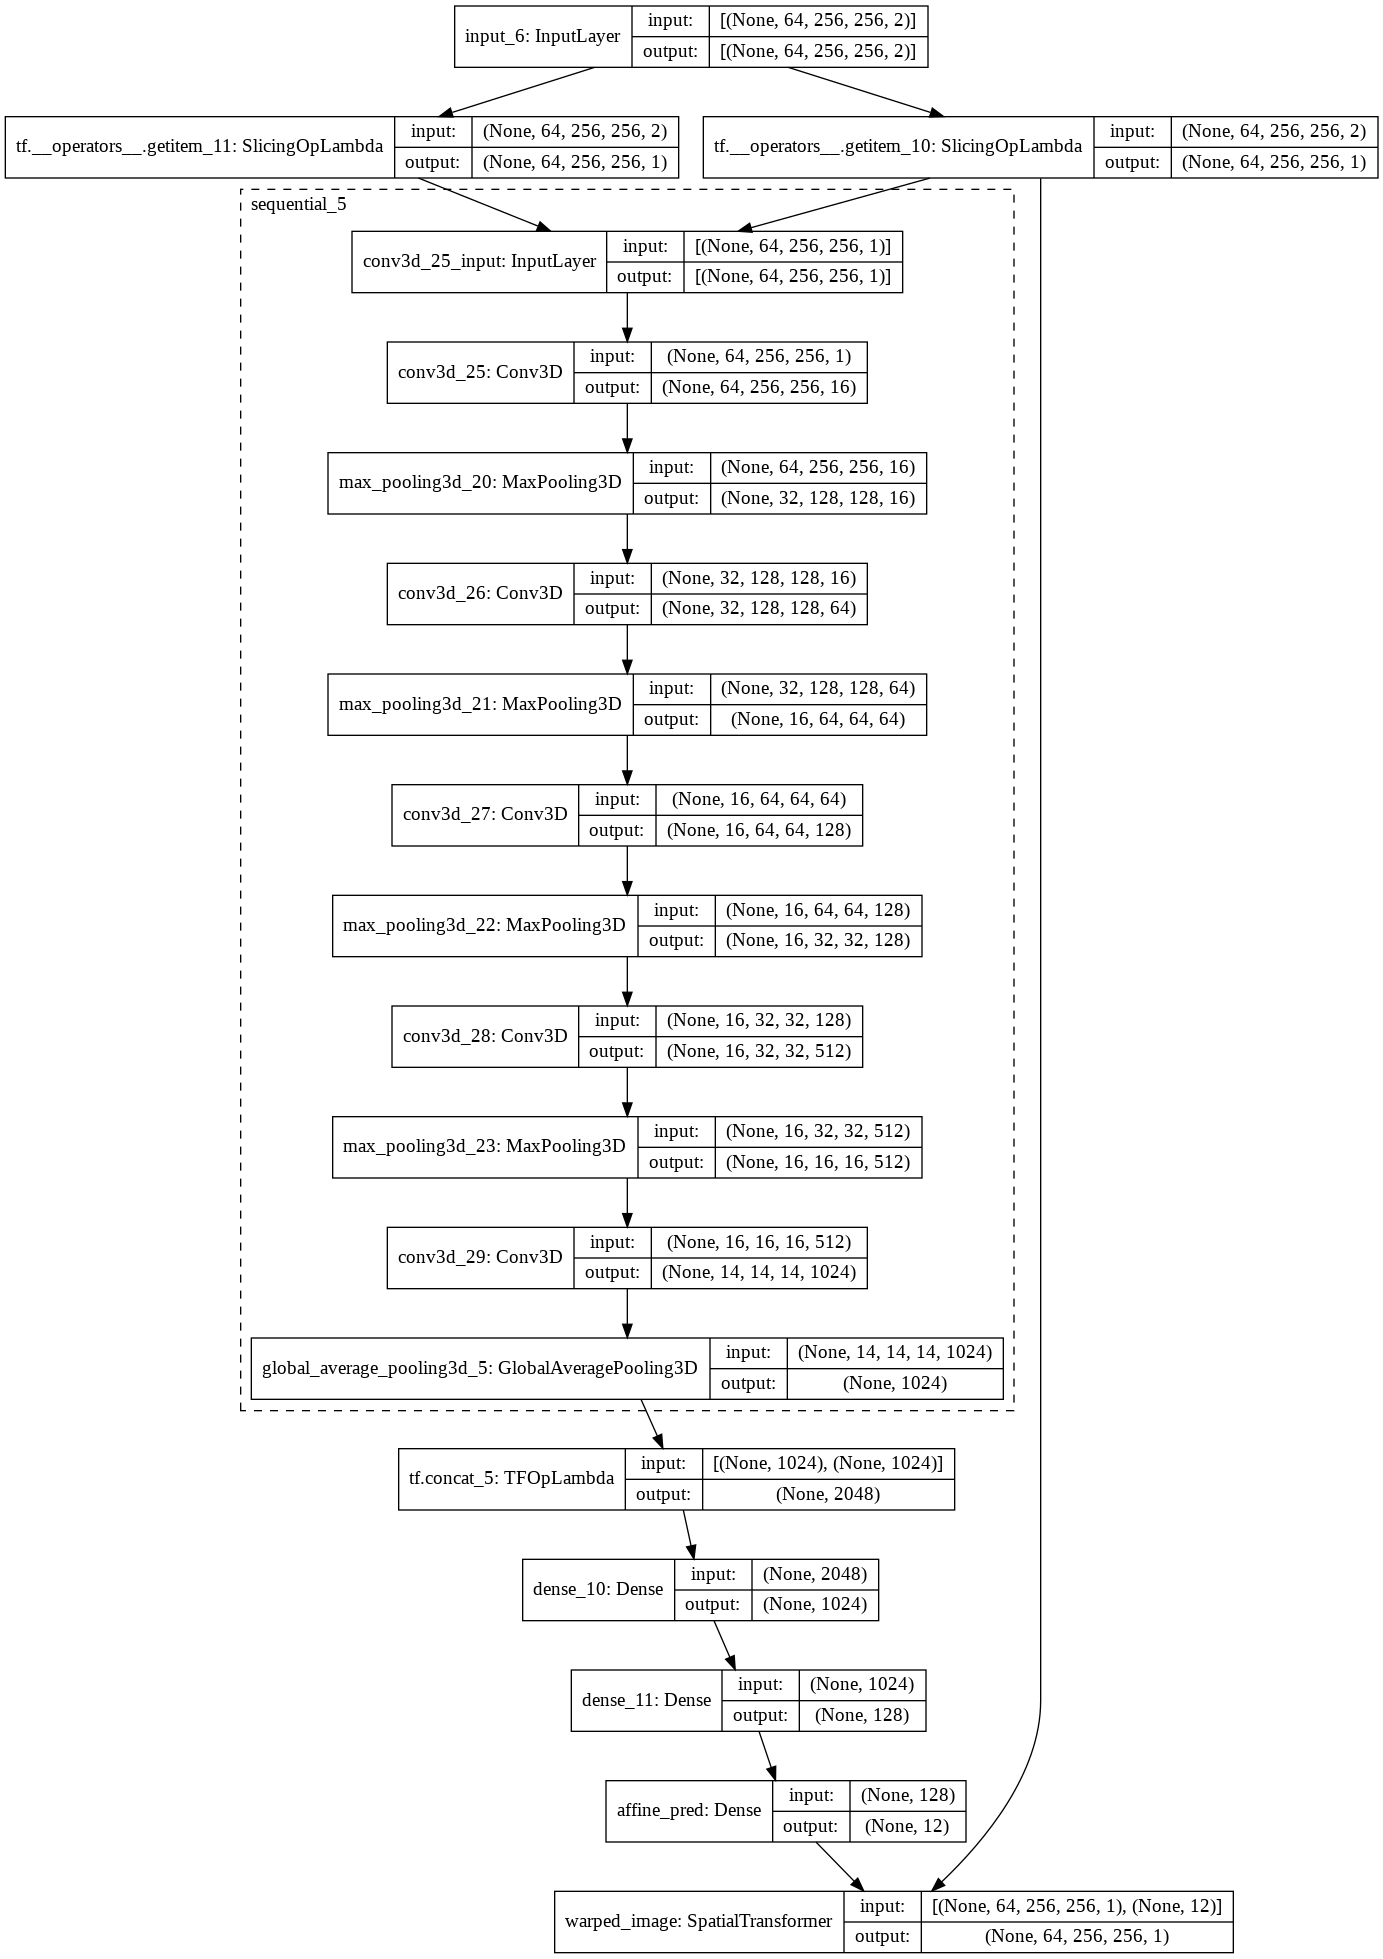

In [ ]:
keras.utils.plot_model(model, "./model_img/DLIR.png", show_shapes=True, expand_nested=True)

#### model with separate representation

In [ ]:
class affine_rep2param(layers.Layer):
    """
    A custom layer to convert affine transformation representation
    to the 12 affine transformation parameters
    """
    def __init__(self, name="affine_rep2param", **kwargs):
        kwargs.update({
            "trainable":False,
            "name":name
        })
        super(self.__class__, self).__init__(**kwargs)
        # super(self.__class__, self).__init__(trainable=False)
        self.rep_length = 18
    
    def build(self, input_shape):
        assert input_shape[1] == self.rep_length
        self.built = True
    
    def get_config(self):
        return super().get_config().copy()
    
    def call(self, input, training=True):
        assert input.shape[1] == self.rep_length
        # necessary for multi_gpu models ?
        input = K.reshape(input, (-1, self.rep_length))

        # convert affine rep to 12 params of affine transformation matrix
        if training:
            return tf.map_fn(self.single_rep2param, input, fn_output_signature=tf.float32)
        else: # using symmetric_orthogonalization
            return tf.map_fn(self.single_rep2param_svd, input, fn_output_signature=tf.float32)
        
        # # bs = tf.shape(input)[0] # tf.shape: https://stackoverflow.com/questions/38236175/get-the-size-of-a-variable-batch-dimension
        # # bs = input.get_shape()[0] 
        # trans, rot, scale, shear_param = input[:, 0:3], input[:, 3:12], \
        #                                  input[:, 12:15], input[:, 15:18]
        # affine_param = K.variable(lambda : K.eye(3)[None, ...])
        # affine_param = K.variable(lambda : K.repeat_elements(affine_param, rep=bs, axis=0))
        # affine_param = affine_param[:, 0, 1].assign(shear_param[:, 0])
        # affine_param = affine_param[:, 0, 2].assign(shear_param[:, 1])
        # affine_param = affine_param[:, 1 ,2].assign(shear_param[:, 2])
        # affine_param = affine_param * K.reshape(scale, (-1, 1, 3))
        # affine_param = K.reshape(rot, (-1, 3, 3)) @ affine_param
        # # if training:
        # #     affine_param = K.reshape(rot, (bs, 3, 3)) @ affine_param
        # # else:
        # #     pass
        # affine_param = tf.concat([affine_param, K.reshape(trans, (-1, 3, 1))], axis = 2)
        # return K.reshape(affine_param, (-1, 12))
        
    @classmethod
    def single_rep2param(cls, rep):
        """
        convert a single affine representation of length-18 tensors to 
        affine parameters of length-12 tensors
        """
        trans, rot, scale, shear_param = rep[0:3], rep[3:12], \
                                     rep[12:15], rep[15:18]
        # affine_param = K.variable(lambda : K.ones((3,4))) # lambda for variable(): https://stackoverflow.com/questions/61579678/valueerror-tensor-typed-variable-initializers-must-either-be-wrapped-in-an-init
        # affine_param = affine_param[:, 3].assign(trans) # assign: https://stackoverflow.com/questions/57454529/how-to-assign-a-value-to-the-tensor-object-in-keras
        # rot = K.reshape(rot, (3,3))
        # shear = K.variable(lambda : K.eye(3))
        # shear = shear[0,1].assign(shear_param[0])
        # shear = shear[0,2].assign(shear_param[1])
        # shear = shear[1,2].assign(shear_param[2])
        # shear = shear * scale
        # affine_param = affine_param[:, :3].assign(rot @ shear)
        # return K.reshape(affine_param, shape=[-1])

        affine_param = K.variable(lambda : K.eye(3))
        affine_param = affine_param[0,1].assign(shear_param[0])
        affine_param = affine_param[0,2].assign(shear_param[1])
        affine_param = affine_param[1,2].assign(shear_param[2])
        affine_param = affine_param * scale
        affine_param = K.reshape(rot, (3,3)) @ affine_param
        affine_param = tf.concat([affine_param, trans[:, None]], axis = 1)
        return K.reshape(affine_param, shape=[-1])

    @classmethod
    def single_rep2param_svd(cls, rep):
        """
        convert a single affine representation of length-18 tensors to 
        affine parameters of length-12 tensors using symmetric_orthogonalization:
        https://github.com/google-research/google-research/tree/master/special_orthogonalization 
        """
        trans, rot, scale, shear_param = rep[0:3], rep[3:12], \
                                     rep[12:15], rep[15:18]
        affine_param = K.variable(lambda : K.eye(3))
        affine_param = affine_param[0,1].assign(shear_param[0])
        affine_param = affine_param[0,2].assign(shear_param[1])
        affine_param = affine_param[1,2].assign(shear_param[2])
        affine_param = affine_param * scale

        rot = K.reshape(rot, (3,3))
        s,u,v = tf.linalg.svd(rot)
        vt = tf.transpose(v)
        det = tf.linalg.det(u @ vt)
        vt = tf.concat((vt[:2, :], vt[-1:, :] * det), axis=0)
        rot = u @ vt

        affine_param = rot @ affine_param
        affine_param = tf.concat([affine_param, trans[:, None]], axis = 1)
        return K.reshape(affine_param, shape=[-1])

In [ ]:
#### Modified model v3
## 1. use lrelu for all relu
## 2. affine module predicts 18 params

# Get rid of the batch dimension
imgPairShape = list(fixedImg.shape)[1:]
# Change the channel dimension to get the image pair shape
imgPairShape[-1] = 2
inputs = keras.Input(shape = imgPairShape)
moving_input = tf.expand_dims(inputs[:, :, :, :, 0], axis = -1)
fixed_input = tf.expand_dims(inputs[:, :, :, :, 1], axis = -1)

down_depths = [4, 8, 16, 24, 32]
# up_depths = [2, 16, 32, 16, 3]
lrelu = layers.LeakyReLU(alpha=0.1)

conv_0 = layers.Conv3D(filters=down_depths[0], kernel_size=(6, 32, 32), strides=(1, 2, 2), activation=lrelu)(moving_input)
print("conv_0: {}".format(conv_0.shape))
conv_1 = layers.Conv3D(filters=down_depths[1], kernel_size=(6, 16, 16), activation=lrelu)(conv_0)
print("conv_1: {}".format(conv_1.shape))
filtered_conv_1 = layers.MaxPool3D((2, 2, 2))(conv_1)
print("filtered_conv_1: {}".format(filtered_conv_1.shape))
conv_2 = layers.Conv3D(filters=down_depths[2], kernel_size=(6, 8, 8), activation=lrelu)(filtered_conv_1)
print("conv_2: {}".format(conv_2.shape))
filtered_conv_2 = layers.MaxPool3D((1, 2, 2))(conv_2)
print("filtered_conv_2: {}".format(filtered_conv_2.shape))
conv_3 = layers.Conv3D(filters=down_depths[3], kernel_size=(4, 8, 8), activation=lrelu)(filtered_conv_2)
print("conv_3: {}".format(conv_3.shape))
conv_4 = layers.Conv3D(filters=down_depths[4], kernel_size=(4, 4, 4), activation=lrelu)(conv_3)
print("conv_4: {}".format(conv_4.shape))

f_conv_0 = layers.Conv3D(filters=down_depths[0], kernel_size=(6, 32, 32), strides=(1, 2, 2), activation=lrelu)(fixed_input)
f_conv_1 = layers.Conv3D(filters=down_depths[1], kernel_size=(6, 16, 16), activation=lrelu)(f_conv_0)
f_filtered_conv_1 = layers.MaxPool3D((2, 2, 2))(f_conv_1)
f_conv_2 = layers.Conv3D(filters=down_depths[2], kernel_size=(6, 8, 8), activation=lrelu)(f_filtered_conv_1)
f_filtered_conv_2 = layers.MaxPool3D((1, 2, 2))(f_conv_2)
f_conv_3 = layers.Conv3D(filters=down_depths[3], kernel_size=(4, 8, 8), activation=lrelu)(f_filtered_conv_2)
f_conv_4 = layers.Conv3D(filters=down_depths[4], kernel_size=(4, 4, 4), activation=lrelu)(f_conv_3)

concat_feats = tf.concat([conv_4, f_conv_4], axis = -1)
print(concat_feats.shape)

flattened = layers.Flatten()(concat_feats)
dense_0 = layers.Dense(1024, activation=lrelu)(flattened)
dense_1 = layers.Dense(256, activation=lrelu)(dense_0)
dense_2 = layers.Dense(64, activation=lrelu)(dense_1)
affine_pred_rep = layers.Dense(18, activation="linear", name="affine_pred_rep")(dense_2)
print("affine_pred_rep.shape", affine_pred_rep.shape)
affine_pred = affine_rep2param(name="affine_rep2param")(affine_pred_rep)

# convTransposed_3 = layers.Conv3DTranspose(filters=up_depths[0], kernel_size=(6, 10, 10), activation="relu")(conv_4)
# print("convTransposed_3: {}".format(convTransposed_3.shape))
# filtered_convTransposed_2 = layers.Conv3DTranspose(filters=up_depths[1], kernel_size=(6, 20, 20), activation="relu")(convTransposed_3)
# print("filtered_convTransposed_2: {}".format(filtered_convTransposed_2.shape))
# convTransposed_2 = layers.UpSampling3D((1, 2, 2))(filtered_convTransposed_2)
# print("convTransposed_2: {}".format(convTransposed_2.shape))
# filtered_convTransposed_1 = layers.Conv3DTranspose(filters=up_depths[2], kernel_size=(3, 15, 15), activation="relu")(convTransposed_2)
# print("filtered_convTransposed_1: {}".format(filtered_convTransposed_1.shape))
# convTransposed_1 = layers.UpSampling3D((2, 2, 2))(filtered_convTransposed_1)
# print("convTransposed_1: {}".format(convTransposed_1.shape))
# convTransposed_0 = layers.Conv3DTranspose(filters=up_depths[3], kernel_size=(3, 16, 16), activation="relu")(convTransposed_1)
# print("convTransposed_0: {}".format(convTransposed_0.shape))
# deformation_field_pred = layers.Conv3DTranspose(filters=up_depths[4], kernel_size=(3, 10, 10), activation="relu")(convTransposed_0)
# print("deformation_field_pred: {}".format(deformation_field_pred.shape))

affine_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=True)([moving_input, affine_pred])
# deformable_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=False)([affine_warped, deformation_field_pred])
print("affine_warped.shape", affine_warped.shape)

conv_0: (None, 47, 113, 113, 4)
conv_1: (None, 42, 98, 98, 8)
filtered_conv_1: (None, 21, 49, 49, 8)
conv_2: (None, 16, 42, 42, 16)
filtered_conv_2: (None, 16, 21, 21, 16)
conv_3: (None, 13, 14, 14, 24)
conv_4: (None, 10, 11, 11, 32)
(None, 10, 11, 11, 64)
affine_pred_rep.shape (None, 18)
self.bs None
Instructions for updating:
Use fn_output_signature instead
affine_warped.shape (None, 52, 256, 256, 1)


In [ ]:
model = keras.Model(inputs=inputs, outputs=[affine_warped, affine_pred_rep], name="combined_model")
model.summary(line_length=150)

NameError: ignored

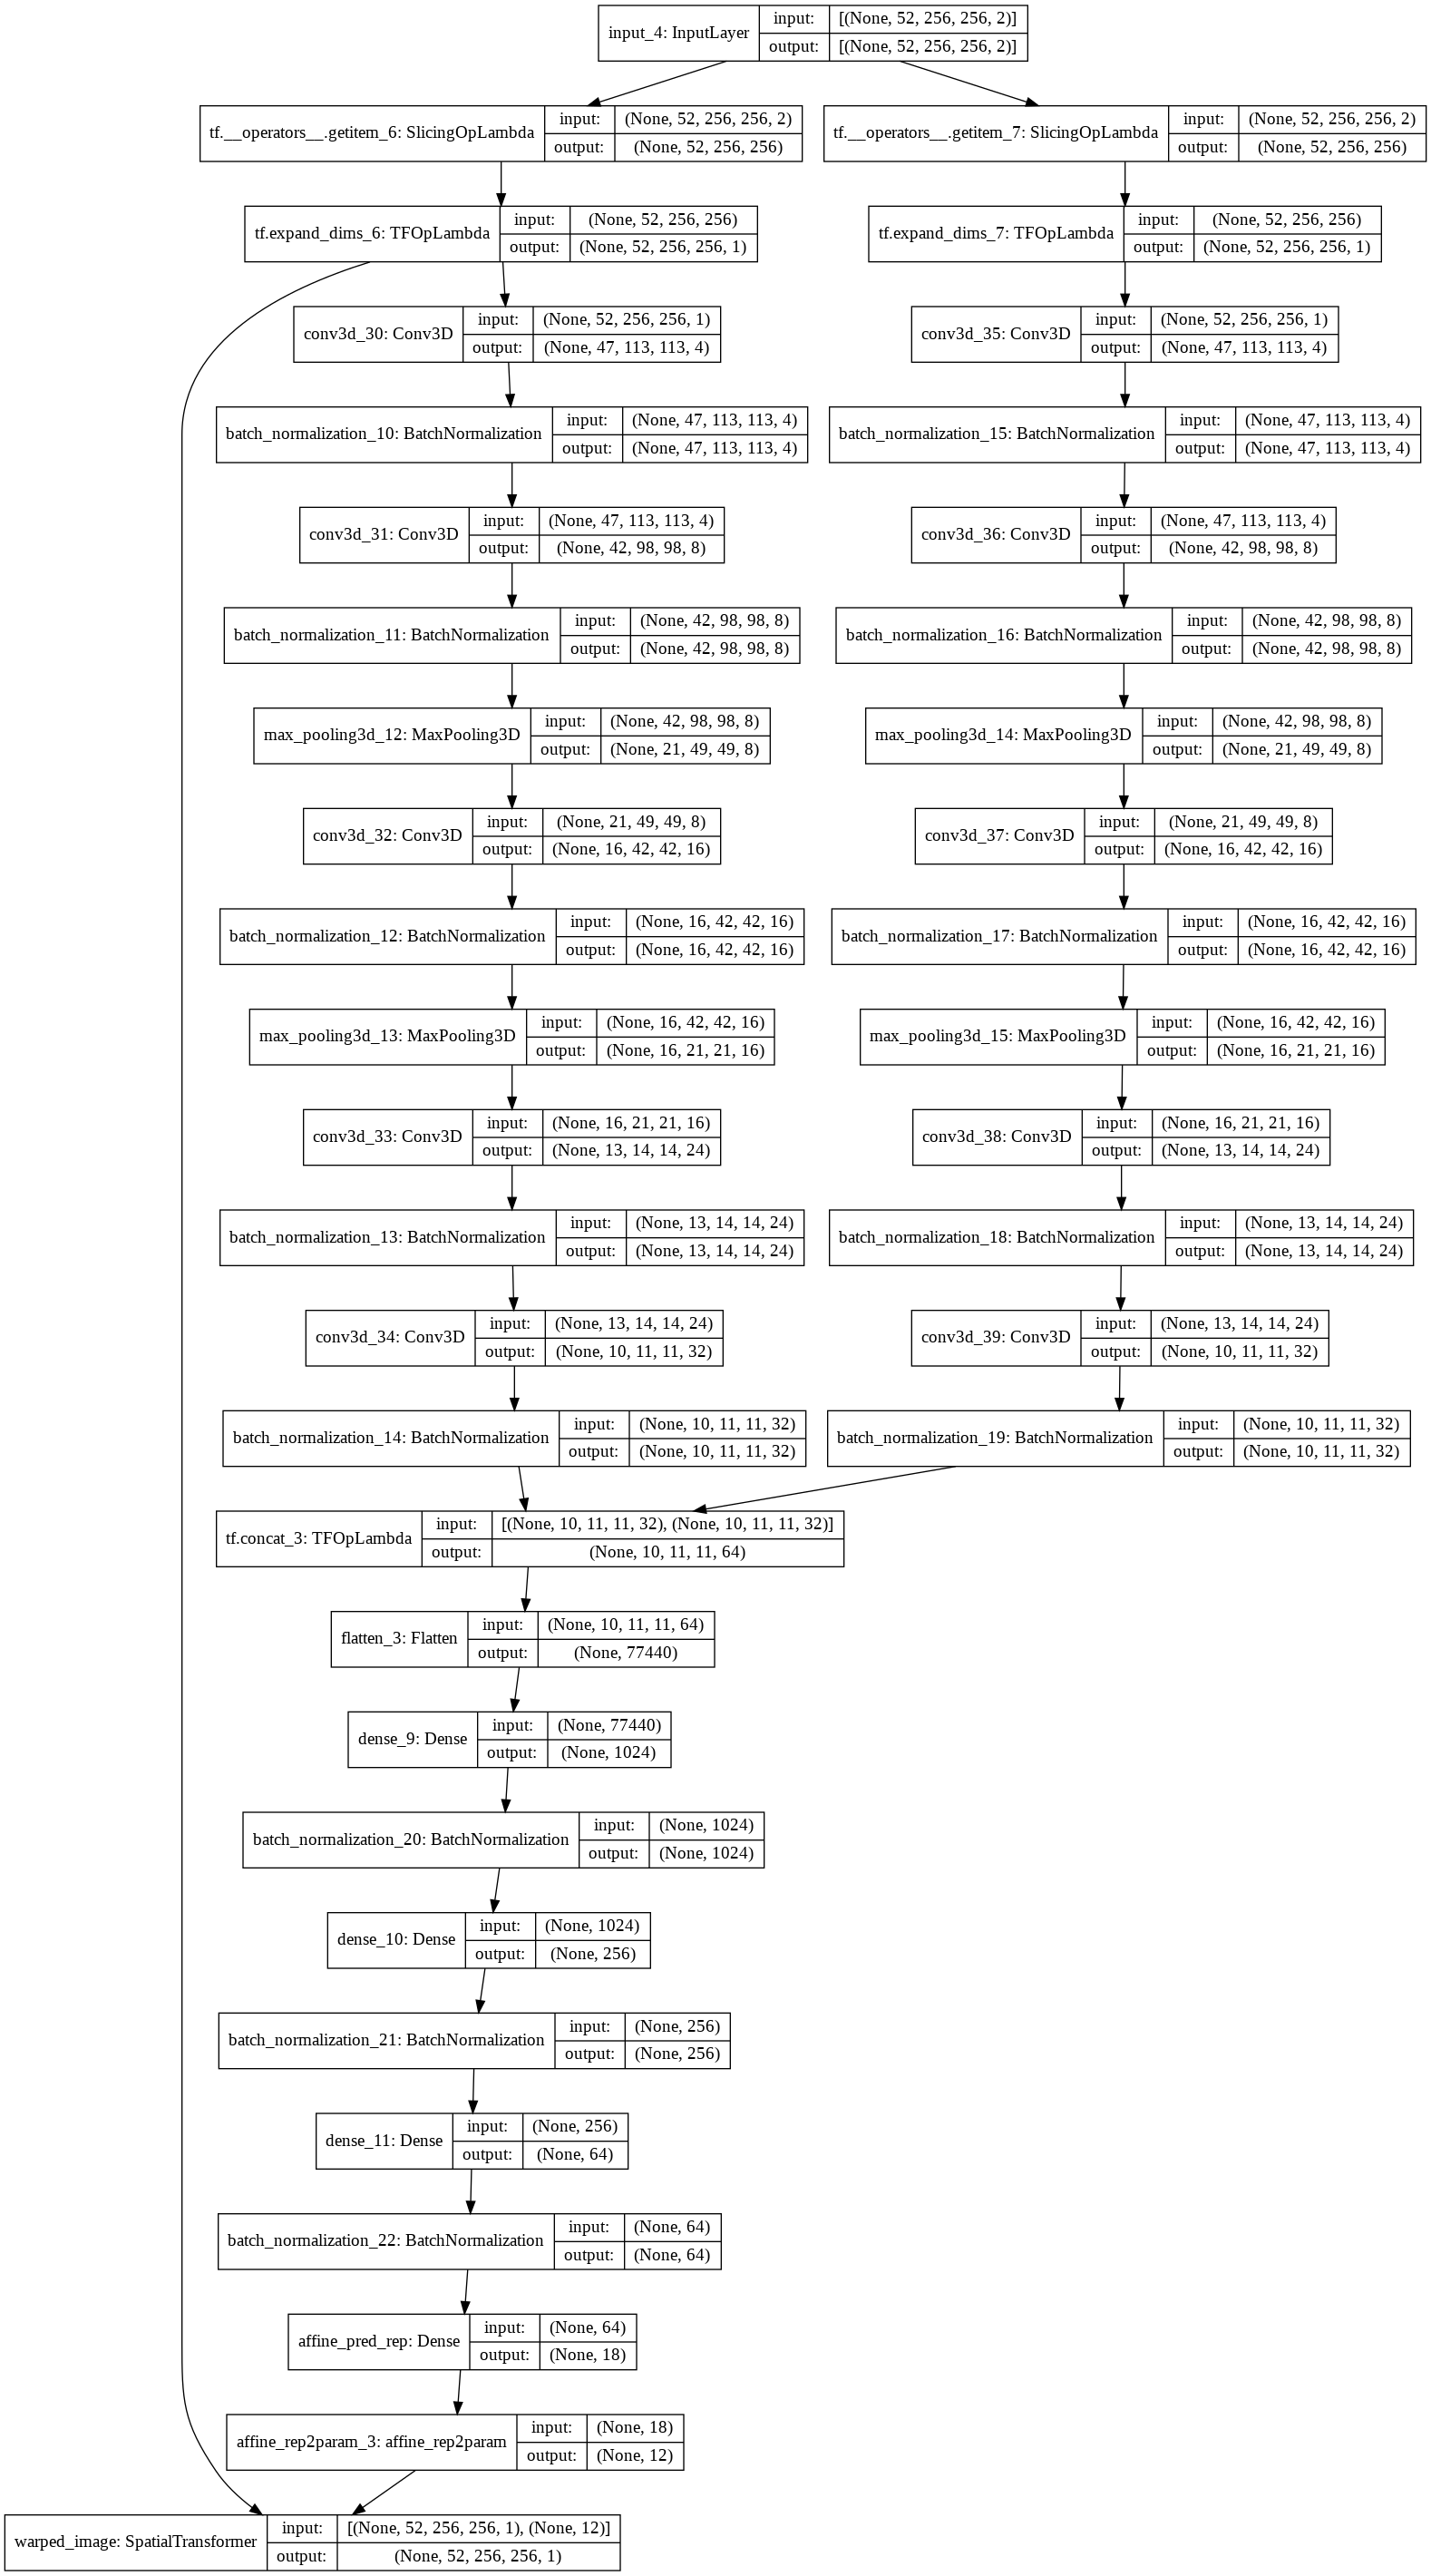

In [ ]:
keras.utils.plot_model(model, "test4.png", show_shapes=True)

In [ ]:
# """
# y = (deformed_img, affine_trf)
# """
# def affine_loss(y_actual, y_pred):
#     y_actual = y_actual[0]
#     y_pred = y_pred[0]
#     tgtDiag = [y_actual[0]] + [y_actual[5]] + [y_actual[10]]
#     predDiag = [y_pred[0]] + [y_pred[5]] + [y_pred[10]]
#     tgtCorner = y_actual[1:3] + [y_actual[4]] + [y_actual[6]] + y_actual[8:10]
#     predCorner = y_pred[1:3] + [y_pred[4]] + [y_pred[6]] + y_pred[8:10]
#     tgtTranslation = [y_actual[3]] + [y_actual[7]] + [y_actual[11]]
#     predTranslation = [y_pred[3]] + [y_pred[7]] + [y_pred[11]]
#     mse = tf.keras.losses.MeanSquaredError()
#     diag_loss = mse(tgtDiag, predDiag)
#     corner_loss = mse(tgtCorner, predCorner)
#     translation_loss = mse(tgtTranslation, predTranslation)
#     return corner_loss * 10 + diag_loss * 10 + translation_loss

#### Train

In [ ]:
## Training 
# experiment_name = "qr_decomp_svd_rot_batchnorm"
# experiment_name = "qr_decomp_svd_rot"
experiment_name = "baseline_DLIR"
lr = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
output_dir = os.path.join("checkpoints", experiment_name, time.strftime("%m_%d_%H-%M-%S"))
save_callback = ModelCheckpoint(os.path.join(output_dir, "{epoch:02d}.h5"),
                                # monitor='val_warped_image_mean_squared_error',
                                save_best_only=True,
                                )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=4, min_lr=0.000005)

model.compile(optimizer=optimizer,
              loss={"warped_image":"mean_squared_error", "affine_pred":"mean_squared_error"},
              loss_weights={"warped_image":5, "affine_pred":1},
              run_eagerly=False)

# model.compile(optimizer=optimizer,
#               loss={"warped_image":"mean_squared_error", "affine_pred_rep":"mean_absolute_error"},
#             #   loss_weights={"warped_image":1, "affine_pred":1},
#             #   metrics={"warped_image":"mean_squared_error"},
#               run_eagerly=True)

In [ ]:
batchSize=2
dataGen = data_generator(batchSize=batchSize)
val_dataGen = data_generator(batchSize=batchSize)

In [ ]:
# model.fit(dataGen, epochs=20, steps_per_epoch=trainDataSize, callbacks=[save_callback])
# trainDataSize=30
# trainDataSize=20
# trainDataSize=40
# valDataSize=8
trainDataSize=80
valDataSize=20
epochs=100

os.makedirs(output_dir)

results = model.fit(dataGen, epochs=epochs, steps_per_epoch=trainDataSize, 
                    validation_data=val_dataGen, validation_steps=valDataSize,
                    callbacks=[save_callback])

print("output_dir:", output_dir, "\n")
model.save(os.path.join(output_dir, "final_model.h5"))
with open(os.path.join(output_dir, "results.pkl"), "wb") as f:
    pickle.dump(results.history, f)

Epoch 1/100
80/80 [==============================] - 232s 3s/step - loss: 10.0610 - warped_image_loss: 0.0624 - affine_pred_loss: 9.7490 - val_loss: 8.5908 - val_warped_image_loss: 0.0601 - val_affine_pred_loss: 8.2904
Epoch 2/100
80/80 [==============================] - 220s 3s/step - loss: 7.5072 - warped_image_loss: 0.0542 - affine_pred_loss: 7.2362 - val_loss: 8.0684 - val_warped_image_loss: 0.0449 - val_affine_pred_loss: 7.8437
Epoch 3/100
80/80 [==============================] - 218s 3s/step - loss: 7.9264 - warped_image_loss: 0.0549 - affine_pred_loss: 7.6519 - val_loss: 7.6159 - val_warped_image_loss: 0.0750 - val_affine_pred_loss: 7.2411
Epoch 4/100
80/80 [==============================] - 213s 3s/step - loss: 8.4778 - warped_image_loss: 0.0627 - affine_pred_loss: 8.1641 - val_loss: 6.0831 - val_warped_image_loss: 0.0449 - val_affine_pred_loss: 5.8587
Epoch 5/100
80/80 [==============================] - 230s 3s/step - loss: 7.9894 - warped_image_loss: 0.0565 - affine_pred_loss

#### Plot training curves

In [ ]:
 def plot_loss(history, ylim=None):
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    if ylim:
        plt.ylim(ylim)
    plt.legend(['train', 'val'])
    plt.show()

def plot_accuracy(history, metric_name="warped_image_mean_squared_error"):
    assert metric_name in history and "val_"+metric_name in history, "history doesn't contain such metric"
    plt.plot(history[metric_name])
    plt.plot(history['val_' + metric_name])
    plt.title(f"Train and val {metric_name}")
    plt.ylabel(metric_name)
    plt.xlabel('epoch')
    plt.legend(['train', 'val']) #, loc='upper left'
    plt.show()

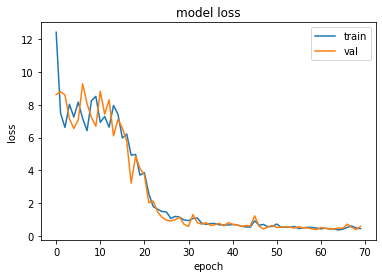

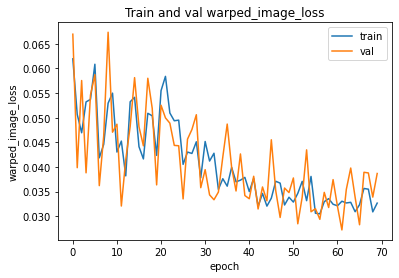

In [ ]:
## model 4.5.3 DLIR
plot_loss(results.history, ylim=None)
plot_accuracy(results.history, metric_name="warped_image_loss")

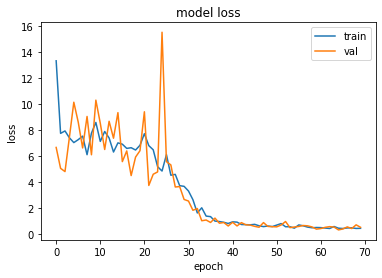

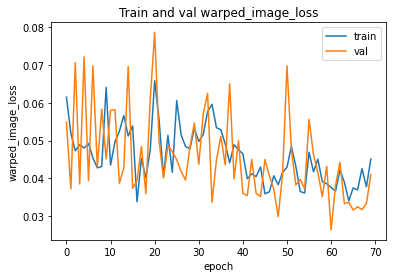

In [ ]:
## model 4.5.2 DLIR
# result_path = "checkpoints/DLIR_2/10_13_11-48-33/results.pkl"
# with open(result_path, "rb") as f:
#     history = pickle.load(f)

# plot_loss(history, ylim=None)
# plot_accuracy(history, metric_name="warped_image_loss")
plot_loss(results.history, ylim=None)
plot_accuracy(results.history, metric_name="warped_image_loss")

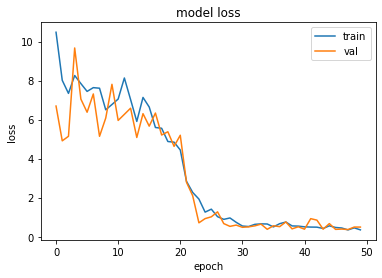

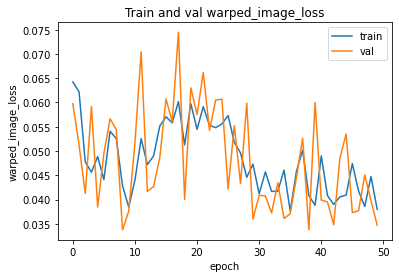

In [ ]:
## model 4.5 DLIR
# result_path = "checkpoints/DLIR_2/10_13_11-48-33/results.pkl"
# with open(result_path, "rb") as f:
#     history = pickle.load(f)

# plot_loss(history, ylim=None)
# plot_accuracy(history, metric_name="warped_image_loss")
plot_loss(results.history, ylim=None)
plot_accuracy(results.history, metric_name="warped_image_loss")

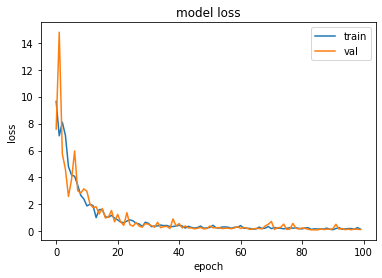

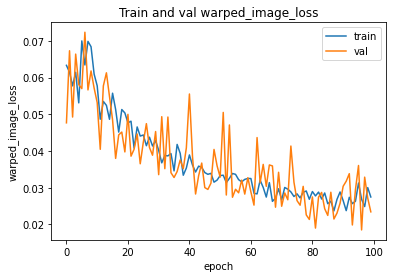

In [ ]:
## model 4.4.2 DLIR 2
plot_loss(results.history, ylim=None)
plot_accuracy(results.history, metric_name="warped_image_loss")

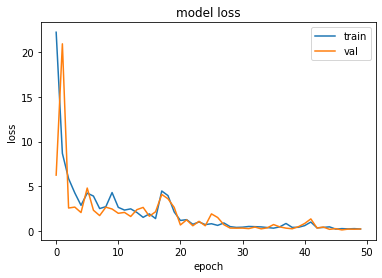

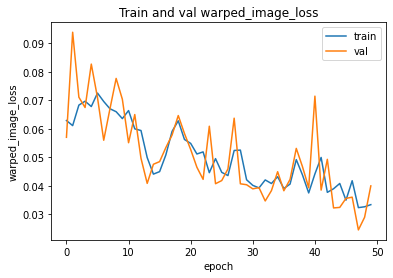

In [ ]:
## model 4.4 DLIR 2
result_path = "checkpoints/DLIR_2/10_13_11-48-33/results.pkl"
with open(result_path, "rb") as f:
    history = pickle.load(f)

plot_loss(history, ylim=None)
plot_accuracy(history, metric_name="warped_image_loss")

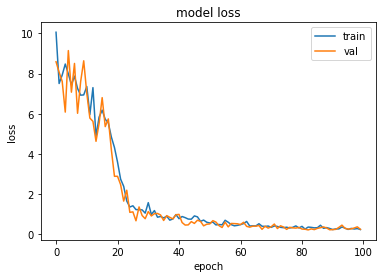

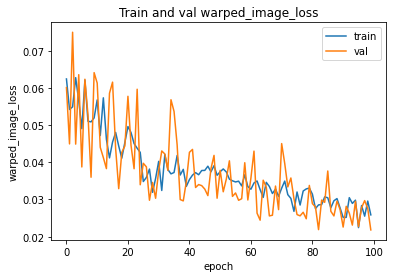

In [ ]:
## model 4.3.2 baseline DLIR
plot_loss(results.history, ylim=None)
plot_accuracy(results.history, metric_name="warped_image_loss")

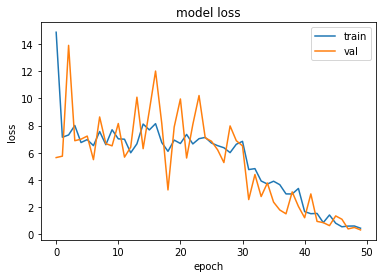

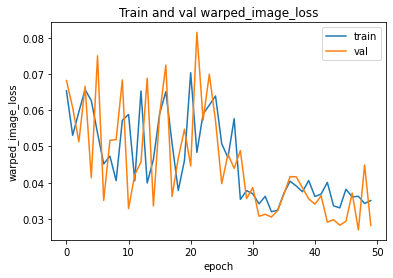

In [ ]:
## model 4.3 baseline DLIR
result_path = "checkpoints/baseline_DLIR/10_13_05-22-00/results.pkl"
with open(result_path, "rb") as f:
    history = pickle.load(f)

plot_loss(history, ylim=None)
plot_accuracy(history, metric_name="warped_image_loss")

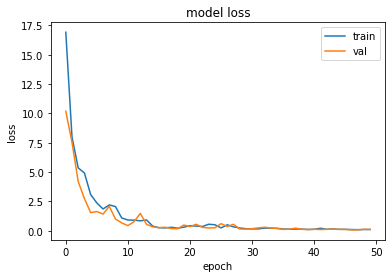

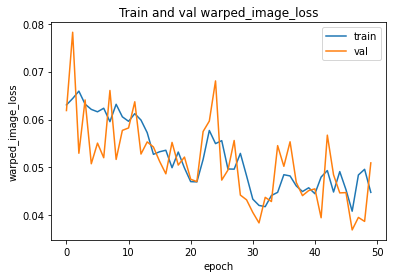

In [ ]:
## model 4.2 baseline
plot_loss(results.history, ylim=None)
plot_accuracy(results.history, metric_name="warped_image_loss")

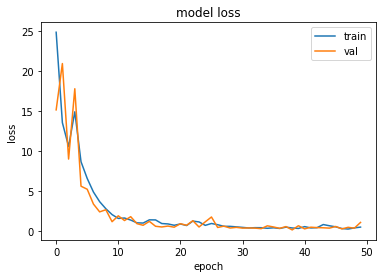

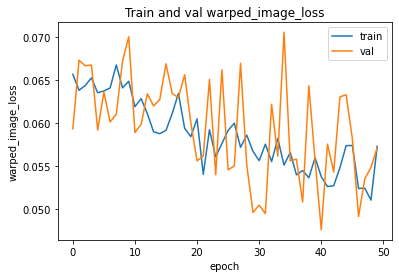

In [ ]:
## model 4
plot_loss(results.history, ylim=None)
plot_accuracy(results.history, metric_name="warped_image_loss")

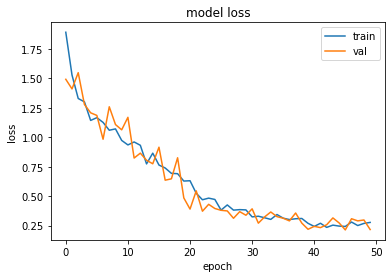

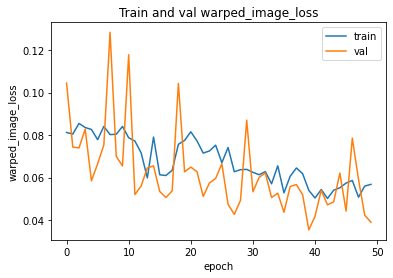

In [ ]:
## model 3_2
plot_loss(results.history, ylim=None)
plot_accuracy(results.history, metric_name="warped_image_loss")

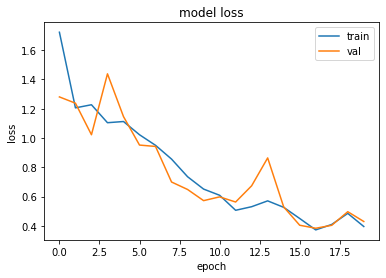

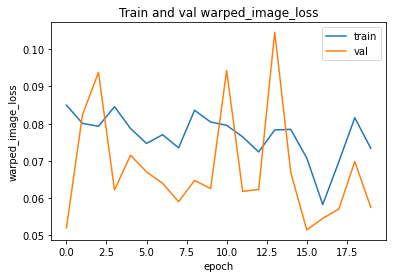

In [ ]:
## model 3
plot_loss(results.history, ylim=None)
plot_accuracy(results.history, metric_name="warped_image_loss")

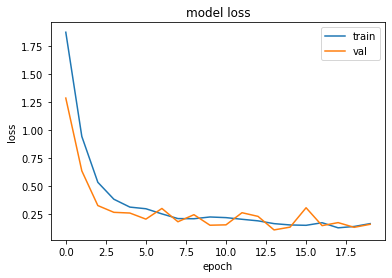

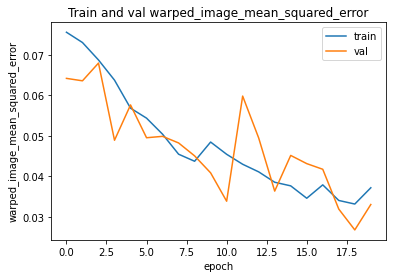

In [ ]:
## model 1
plot_loss(results.history, ylim=None)
plot_accuracy(results.history, metric_name="warped_image_mean_squared_error")

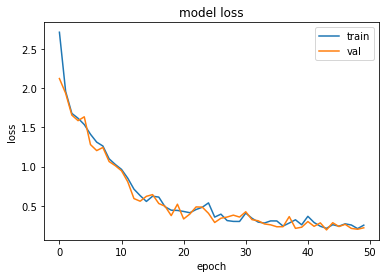

In [ ]:
## model 2
result_path = "checkpoints/08_15_17-40-23/results.pkl"
with open(result_path, "rb") as f:
    history = pickle.load(f)

plot_loss(history, ylim=None)
# plot_accuracy(history, metric_name="warped_image_mean_squared_error")

## Test model (output == warpedImg)

In [ ]:
!ls checkpoints

08_14_22-59-55	08_14_23-59-03	08_15_09-51-38
08_14_23-05-06	08_15_07-38-34	08_15_17-40-23


In [ ]:
testModel = model

In [ ]:
# dataGen = data_generator()
# testModel = keras.Model(inputs=inputs, outputs=[affine_warped, affine_pred])

# testModel.load_weights('./checkpoints/trial/17.h5')
# testModel.load_weights('./checkpoints/08_14_23-05-06/03.h5')
# testModel.load_weights('./checkpoints/08_14_23-59-03/16.h5')
# testModel.load_weights('./checkpoints/08_15_07-38-34/40.h5')

# testModel = model

dataGen = data_generator(batchSize=4)
# testModel = keras.models.load_model('./checkpoints/baseline/10_12_11-17-17/47.h5', custom_objects=
#             {"SpatialTransformer":custom_layers.SpatialTransformer, # (interp_method='linear', add_identity=False, name="warped_image", shift_center=True)
#              "affine_rep2param":affine_rep2param})
testModel = keras.models.load_model('./checkpoints/baseline/10_12_11-17-17/47.h5', custom_objects=
            {"SpatialTransformer":custom_layers.SpatialTransformer, # (interp_method='linear', add_identity=False, name="warped_image", shift_center=True)
            })

Instructions for updating:
Use fn_output_signature instead


#### Result for model 7 DLIR
* 40/40 - 171s 4s/step - loss: 0.3466 - warped_image_loss: 0.0386 - affine_pred_loss: 0.3080 - val_loss: 0.3648 - val_warped_image_loss: 0.0451 - val_affine_pred_loss: 0.3197
* lr = 0.0001 (converged)
* one pipeline processes each image separately
* depth: [16, 64, 128, 512, 1024]

----

* 40/40 - 158s 4s/step - loss: 0.4280 - warped_image_loss: 0.0340 - affine_pred_loss: 0.3940 - val_loss: 0.2957 - val_warped_image_loss: 0.0336 - val_affine_pred_loss: 0.2620
* lr = 0.00005, epoch=70


In [ ]:
# testModel = model
dataGen = data_generator(batchSize=4)
testModel = keras.models.load_model("checkpoints/DLIR/10_14_03-44-18/65.h5", custom_objects=
            {"SpatialTransformer":custom_layers.SpatialTransformer, # (interp_method='linear', add_identity=False, name="warped_image", shift_center=True)
            })

In [ ]:
"""
40/40 - 171s 4s/step - loss: 0.3466 - warped_image_loss: 0.0386 - affine_pred_loss: 0.3080 - val_loss: 0.3648 - val_warped_image_loss: 0.0451 - val_affine_pred_loss: 0.3197
lr = 0.0001 (converged)
one pipeline processes each image separately
depth: [16, 64, 128, 512, 1024]
"""
moving_test, label_test = next(dataGen)
num_show = 4
slice_num_show = 10 # >1
slice_interval = 2
moving_test, gt_trf = moving_test[:num_show], label_test[1][:num_show]
(warped_test, affine_pred_test) = testModel(moving_test, training=False) # inference mode

sliceToCheck = 20
for i in range(num_show):
    mse = ((label_test[0][i] - warped_test[i].numpy())**2).mean()
    print("Sample mse:", mse)
    print((f"  Sample {i}, slice {sliceToCheck} ~ {sliceToCheck}+{slice_interval}*{slice_num_show}"))

    fig, axes = plt.subplots(slice_num_show,3, figsize=(10,3*slice_num_show))
    for j in range(slice_num_show):
        # axes[j,1].imshow(fixedImg[0,sliceToCheck + j * slice_interval,...,0])   # M
        axes[j,0].imshow(label_test[0][i,sliceToCheck + j * slice_interval,:,:,0]) # F
        axes[j,1].imshow(moving_test[i,sliceToCheck + j * slice_interval,:,:,0])   # M
        axes[j,2].imshow(warped_test[i,sliceToCheck + j * slice_interval,:,:,0])
    axes[0,0].set_title("Fixed")
    axes[0,1].set_title("Moving")
    axes[0,2].set_title("Wrapped")
    plt.tight_layout()
    plt.show()
    print("------------------")

# print(["{:f.3}".format(x) for x in gt_trf])
print(gt_trf.round(3).reshape(-1,3,4))
print("------------------")
print(affine_pred_test.numpy().round(3).reshape(-1,3,4))
print("------------------")

Output hidden; open in https://colab.research.google.com to view.

#### Result for model 6 DLIR 2

* 80/80 - 188s 2s/step - loss: 0.1700 - warped_image_loss: 0.0256 - affine_pred_loss: 0.1187 - val_loss: 0.1090 - val_warped_image_loss: 0.0225 - val_affine_pred_loss: 0.0641
* lr = 0.0001 (converged), 100 epoch, 2 bs, 80 ierations, 2:1 loss weight
* one pipeline processes both image together

In [ ]:
dataGen = data_generator(batchSize=2)
testModel = model

In [ ]:
moving_test, label_test = next(dataGen)
num_show = 2
slice_num_show = 10 # >1
slice_interval = 2
moving_test, gt_trf = moving_test[:num_show], label_test[1][:num_show]
(warped_test, affine_pred_test) = testModel(moving_test, training=False) # inference mode

sliceToCheck = 20
for i in range(num_show):
    mse = ((label_test[0][i] - warped_test[i].numpy())**2).mean()
    print("Sample mse:", mse)
    print((f"  Sample {i}, slice {sliceToCheck} ~ {sliceToCheck}+{slice_interval}*{slice_num_show}"))

    fig, axes = plt.subplots(slice_num_show,3, figsize=(10,3*slice_num_show))
    for j in range(slice_num_show):
        # axes[j,1].imshow(fixedImg[0,sliceToCheck + j * slice_interval,...,0])   # M
        axes[j,0].imshow(label_test[0][i,sliceToCheck + j * slice_interval,:,:,0]) # F
        axes[j,1].imshow(moving_test[i,sliceToCheck + j * slice_interval,:,:,0])   # M
        axes[j,2].imshow(warped_test[i,sliceToCheck + j * slice_interval,:,:,0])
    axes[0,0].set_title("Fixed")
    axes[0,1].set_title("Moving")
    axes[0,2].set_title("Wrapped")
    plt.tight_layout()
    plt.show()
    print("------------------")

# print(["{:f.3}".format(x) for x in gt_trf])
print(gt_trf.round(3).reshape(-1,3,4))
print("------------------")
print(affine_pred_test.numpy().round(3).reshape(-1,3,4))
print("------------------")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
moving_test, label_test = next(dataGen)
num_show = 2
slice_num_show = 10 # >1
slice_interval = 2
moving_test, gt_trf = moving_test[:num_show], label_test[1][:num_show]
(warped_test, affine_pred_test) = testModel(moving_test, training=False) # inference mode

sliceToCheck = 20
for i in range(num_show):
    mse = ((label_test[0][i] - warped_test[i].numpy())**2).mean()
    print("Sample mse:", mse)
    print((f"  Sample {i}, slice {sliceToCheck} ~ {sliceToCheck}+{slice_interval}*{slice_num_show}"))

    fig, axes = plt.subplots(slice_num_show,3, figsize=(10,3*slice_num_show))
    for j in range(slice_num_show):
        # axes[j,1].imshow(fixedImg[0,sliceToCheck + j * slice_interval,...,0])   # M
        axes[j,0].imshow(label_test[0][i,sliceToCheck + j * slice_interval,:,:,0]) # F
        axes[j,1].imshow(moving_test[i,sliceToCheck + j * slice_interval,:,:,0])   # M
        axes[j,2].imshow(warped_test[i,sliceToCheck + j * slice_interval,:,:,0])
    axes[0,0].set_title("Fixed")
    axes[0,1].set_title("Moving")
    axes[0,2].set_title("Wrapped")
    plt.tight_layout()
    plt.show()
    print("------------------")

# print(["{:f.3}".format(x) for x in gt_trf])
print(gt_trf.round(3).reshape(-1,3,4))
print("------------------")
print(affine_pred_test.numpy().round(3).reshape(-1,3,4))
print("------------------")

Output hidden; open in https://colab.research.google.com to view.

* 40/40 - 168s 4s/step - loss: 0.2386 - warped_image_loss: 0.0324 - affine_pred_loss: 0.2062 - val_loss: 0.2132 - val_warped_image_loss: 0.0246 - val_affine_pred_loss: 0.1886
* lr = 0.001 
* one pipeline processes both image together

In [ ]:
dataGen = data_generator(batchSize=4)
testModel = keras.models.load_model("checkpoints/DLIR_2/10_13_11-48-33/47.h5", custom_objects=
            {"SpatialTransformer":custom_layers.SpatialTransformer, # (interp_method='linear', add_identity=False, name="warped_image", shift_center=True)
            })
# testModel = keras.models.load_model("checkpoints/baseline_DLIR/10_13_05-22-00/50.h5", custom_objects=
#             {"SpatialTransformer":custom_layers.SpatialTransformer, # (interp_method='linear', add_identity=False, name="warped_image", shift_center=True)
#             })

Instructions for updating:
Use fn_output_signature instead


In [ ]:
moving_test, label_test = next(dataGen)
num_show = 4
slice_num_show = 10 # >1
slice_interval = 2
moving_test, gt_trf = moving_test[:num_show], label_test[1][:num_show]
(warped_test, affine_pred_test) = testModel(moving_test, training=False) # inference mode

sliceToCheck = 20
for i in range(num_show):
    mse = ((label_test[0][i] - warped_test[i].numpy())**2).mean()
    print("Sample mse:", mse)
    print((f"  Sample {i}, slice {sliceToCheck} ~ {sliceToCheck}+{slice_interval}*{slice_num_show}"))

    fig, axes = plt.subplots(slice_num_show,3, figsize=(10,3*slice_num_show))
    for j in range(slice_num_show):
        # axes[j,1].imshow(fixedImg[0,sliceToCheck + j * slice_interval,...,0])   # M
        axes[j,0].imshow(label_test[0][i,sliceToCheck + j * slice_interval,:,:,0]) # F
        axes[j,1].imshow(moving_test[i,sliceToCheck + j * slice_interval,:,:,0])   # M
        axes[j,2].imshow(warped_test[i,sliceToCheck + j * slice_interval,:,:,0])
    axes[0,0].set_title("Fixed")
    axes[0,1].set_title("Moving")
    axes[0,2].set_title("Wrapped")
    plt.tight_layout()
    plt.show()
    print("------------------")

# print(["{:f.3}".format(x) for x in gt_trf])
print(gt_trf.round(3).reshape(-1,3,4))
print("------------------")
print(affine_pred_test.numpy().round(3).reshape(-1,3,4))
print("------------------")

Output hidden; open in https://colab.research.google.com to view.

#### Result for model 5 baseline_DLIR
* Epoch 100/100, 80/80  - 200s 3s/step - loss: 0.2332 - warped_image_loss: 0.0259 - affine_pred_loss: 0.1039 - val_loss: 0.2456 - val_warped_image_loss: 0.0218 - val_affine_pred_loss: 0.1365
* lr = 0.0001 (converged), 100 epoch, 2 bs, 80 ierations, 4:1 loss weight
* add lr scheduler


In [ ]:
dataGen = data_generator(batchSize=2)
testModel = model

In [ ]:
moving_test, label_test = next(dataGen)
num_show = 2
slice_num_show = 10 # >1
slice_interval = 2
moving_test, gt_trf = moving_test[:num_show], label_test[1][:num_show]
(warped_test, affine_pred_test) = testModel(moving_test, training=False) # inference mode

sliceToCheck = 20
for i in range(num_show):
    mse = ((label_test[0][i] - warped_test[i].numpy())**2).mean()
    print("Sample mse:", mse)
    print((f"  Sample {i}, slice {sliceToCheck} ~ {sliceToCheck}+{slice_interval}*{slice_num_show}"))

    fig, axes = plt.subplots(slice_num_show,3, figsize=(10,3*slice_num_show))
    for j in range(slice_num_show):
        # axes[j,1].imshow(fixedImg[0,sliceToCheck + j * slice_interval,...,0])   # M
        axes[j,0].imshow(label_test[0][i,sliceToCheck + j * slice_interval,:,:,0]) # F
        axes[j,1].imshow(moving_test[i,sliceToCheck + j * slice_interval,:,:,0])   # M
        axes[j,2].imshow(warped_test[i,sliceToCheck + j * slice_interval,:,:,0])
    axes[0,0].set_title("Fixed")
    axes[0,1].set_title("Moving")
    axes[0,2].set_title("Wrapped")
    plt.tight_layout()
    plt.show()
    print("------------------")

# print(["{:f.3}".format(x) for x in gt_trf])
print(gt_trf.round(3).reshape(-1,3,4))
print("------------------")
print(affine_pred_test.numpy().round(3).reshape(-1,3,4))
print("------------------")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
moving_test, label_test = next(dataGen)
num_show = 2
slice_num_show = 10 # >1
slice_interval = 2
moving_test, gt_trf = moving_test[:num_show], label_test[1][:num_show]
(warped_test, affine_pred_test) = testModel(moving_test, training=False) # inference mode

sliceToCheck = 20
for i in range(num_show):
    mse = ((label_test[0][i] - warped_test[i].numpy())**2).mean()
    print("Sample mse:", mse)
    print((f"  Sample {i}, slice {sliceToCheck} ~ {sliceToCheck}+{slice_interval}*{slice_num_show}"))

    fig, axes = plt.subplots(slice_num_show,3, figsize=(10,3*slice_num_show))
    for j in range(slice_num_show):
        # axes[j,1].imshow(fixedImg[0,sliceToCheck + j * slice_interval,...,0])   # M
        axes[j,0].imshow(label_test[0][i,sliceToCheck + j * slice_interval,:,:,0]) # F
        axes[j,1].imshow(moving_test[i,sliceToCheck + j * slice_interval,:,:,0])   # M
        axes[j,2].imshow(warped_test[i,sliceToCheck + j * slice_interval,:,:,0])
    axes[0,0].set_title("Fixed")
    axes[0,1].set_title("Moving")
    axes[0,2].set_title("Wrapped")
    plt.tight_layout()
    plt.show()
    print("------------------")

# print(["{:f.3}".format(x) for x in gt_trf])
print(gt_trf.round(3).reshape(-1,3,4))
print("------------------")
print(affine_pred_test.numpy().round(3).reshape(-1,3,4))
print("------------------")

Output hidden; open in https://colab.research.google.com to view.


* 2 pipeline + DLIR convNet structure
* bs = 4, 40 batch, 50 epoch
* 40/40 - 149s 4s/step - loss: 0.4286 - warped_image_loss: 0.0351 - affine_pred_loss: 0.3935 - val_loss: 0.3038 - val_warped_image_loss: 0.0282 - val_affine_pred_loss: 0.2756
* 8000 samples aren't enough, can still improve


In [ ]:
dataGen = data_generator(batchSize=4)
testModel = keras.models.load_model("checkpoints/baseline_DLIR/10_13_05-22-00/48.h5", custom_objects=
            {"SpatialTransformer":custom_layers.SpatialTransformer, # (interp_method='linear', add_identity=False, name="warped_image", shift_center=True)
            })
# testModel = keras.models.load_model("checkpoints/baseline_DLIR/10_13_05-22-00/50.h5", custom_objects=
#             {"SpatialTransformer":custom_layers.SpatialTransformer, # (interp_method='linear', add_identity=False, name="warped_image", shift_center=True)
#             })

In [ ]:
moving_test, label_test = next(dataGen)
num_show = 4
slice_num_show = 10 # >1
slice_interval = 2
moving_test, gt_trf = moving_test[:num_show], label_test[1][:num_show]
(warped_test, affine_pred_test) = testModel(moving_test, training=False) # inference mode

sliceToCheck = 20
for i in range(num_show):
    mse = ((label_test[0][i] - warped_test[i].numpy())**2).mean()
    print("Sample mse:", mse)
    print((f"  Sample {i}, slice {sliceToCheck} ~ {sliceToCheck}+{slice_interval}*{slice_num_show}"))

    fig, axes = plt.subplots(slice_num_show,3, figsize=(10,3*slice_num_show))
    for j in range(slice_num_show):
        # axes[j,1].imshow(fixedImg[0,sliceToCheck + j * slice_interval,...,0])   # M
        axes[j,0].imshow(label_test[0][i,sliceToCheck + j * slice_interval,:,:,0]) # F
        axes[j,1].imshow(moving_test[i,sliceToCheck + j * slice_interval,:,:,0])   # M
        axes[j,2].imshow(warped_test[i,sliceToCheck + j * slice_interval,:,:,0])
    axes[0,0].set_title("Fixed")
    axes[0,1].set_title("Moving")
    axes[0,2].set_title("Wrapped")
    plt.tight_layout()
    plt.show()
    print("------------------")

# print(["{:f.3}".format(x) for x in gt_trf])
print(gt_trf.round(3).reshape(-1,3,4))
print("------------------")
print(affine_pred_test.numpy().round(3).reshape(-1,3,4))
print("------------------")

Output hidden; open in https://colab.research.google.com to view.

#### Result for model 4 baseline

In [ ]:
# testModel = model
testModel = keras.models.load_model('./checkpoints/baseline/10_12_11-17-17/47.h5', custom_objects=
            {"SpatialTransformer":custom_layers.SpatialTransformer, # (interp_method='linear', add_identity=False, name="warped_image", shift_center=True)
            })

In [ ]:
moving_test, label_test = next(dataGen)
num_show = 4
slice_num_show = 10 # >1
slice_interval = 2
moving_test, gt_trf = moving_test[:num_show], label_test[1][:num_show]
(warped_test, affine_pred_test) = testModel(moving_test, training=False) # inference mode

sliceToCheck = 20
for i in range(num_show):
    mse = ((label_test[0][i] - warped_test[i])**2).mean()

    fig, axes = plt.subplots(slice_num_show,3, figsize=(10,3*slice_num_show))
    for j in range(slice_num_show):
        # axes[j,1].imshow(fixedImg[0,sliceToCheck + j * slice_interval,...,0])   # M
        axes[j,0].imshow(label_test[0][i,sliceToCheck + j * slice_interval,:,:,0]) # F
        axes[j,1].imshow(moving_test[i,sliceToCheck + j * slice_interval,:,:,0])   # M
        axes[j,2].imshow(warped_test[i,sliceToCheck + j * slice_interval,:,:,0])
    axes[0,0].set_title("Fixed")
    axes[0,1].set_title("Moving")
    axes[0,2].set_title("Wrapped")
    # plt.suptitle(f"Sample {i}, slice {sliceToCheck}~{sliceToCheck}+{slice_interval}*{slice_num_show}")
    plt.tight_layout()
    plt.show()
    print("------------------")

# print(["{:f.3}".format(x) for x in gt_trf])
print(gt_trf.round(3).reshape(-1,3,4))
print("------------------")
print(affine_pred_test.numpy().round(3).reshape(-1,3,4))
print("------------------")

Output hidden; open in https://colab.research.google.com to view.

#### Debug result for modified model 3: qr_decomp_svd_rot

Trained with:  
* 50 epoch, 30 iterations/epoch, 4 batchsize/iter
* lr 0.0001, 
* include warped_image as loss
* lrelu, alpha = 0.1
* data generated with QR decomposition
* rotation representation using SVD

Result: 
* translation, scaling, and rotation seem ok
* shearing is bad (but the numbers themselves are very small)

In [ ]:
def evaluate_model(testModel, dataGen, num=20):
    """
    Evaluate the affine param difference and image mse.
    """
    scores = []
    mses = []
    for _ in tqdm(range(num)):
        moving_test, label_test = next(dataGen)
        gt_trf = label_test[1]
        warped_test, affine_pred_test = testModel(moving_test, training=False) # inference mode
        diff = np.abs(gt_trf - affine_pred_test.numpy())
        scores.append(diff)
        mse = ((warped_test[:,..., 0].numpy() - moving_test[:,..., 1])**2).mean()
        mses.append(mse)
    scores = np.mean(scores, axis=0) # mean of samples
    mses = np.mean(mses)
    if len(scores.shape) >=2:
        scores = np.mean(scores, axis=0) # mean of batches
    return{
        "trans": scores[0:3].mean(),
        "rot": scores[3:12].mean(),
        "scale": scores[12:15].mean(),
        "shear": scores[15:18].mean(),
        "tsf_param_mse": scores.mean(),
        "img_mse": mses,
    }

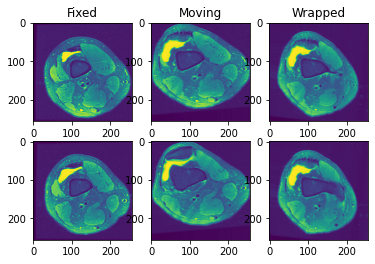

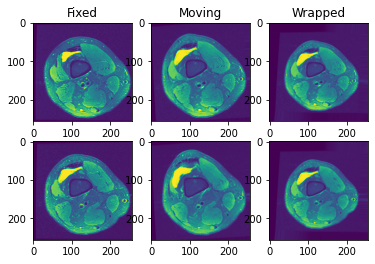

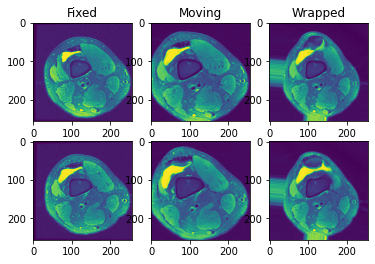

[[-5.6870e+00 -2.2806e+01 -1.9554e+01 -9.9500e-01 -5.6000e-02  8.4000e-02
   4.5000e-02 -9.9100e-01 -1.2600e-01  9.1000e-02 -1.2200e-01  9.8800e-01
  -1.0210e+00 -9.8900e-01  1.1440e+00  1.0000e-03  1.9000e-02 -3.2000e-02]
 [-2.2360e+00 -1.8030e+00 -6.0710e+00 -9.9900e-01 -3.2000e-02  3.5000e-02
   2.9000e-02 -9.9800e-01 -6.0000e-02  3.7000e-02 -5.9000e-02  9.9800e-01
  -1.0180e+00 -1.0090e+00  9.7400e-01  1.0000e-03 -3.0000e-03  4.0000e-03]
 [-2.9270e+00  7.8300e-01 -2.1830e+01 -9.9800e-01 -2.8000e-02  5.1000e-02
   2.5000e-02 -9.9800e-01 -6.5000e-02  5.3000e-02 -6.3000e-02  9.9700e-01
  -9.6900e-01 -1.1240e+00  1.1460e+00 -7.0000e-03  1.5000e-02 -2.0000e-03]]
------------------
[[-6.4404440e+00 -2.4309954e+01 -1.8396910e+01 -8.9828980e-01
   1.3835043e-01  1.5749949e-01  3.5194919e-02 -1.0231466e+00
  -2.9617780e-01  2.5542098e-01  4.6137340e-02  7.8294224e-01
  -9.1683650e-01 -9.9369943e-01  1.1371144e+00  1.0503837e-01
  -6.7846254e-02  5.2312177e-02]
 [-2.4362295e+00 -2.7037911e+0

In [ ]:
moving_test, label_test = next(dataGen)
num_show = 3
slice_num_show = 2 # >1
moving_test, gt_trf = moving_test[:num_show], label_test[1][:num_show]
(warped_test, affine_pred_test) = testModel(moving_test, training=False) # inference mode

sliceToCheck = 0
for i in range(num_show):
    fig, axes = plt.subplots(slice_num_show,3)
    for j in range(slice_num_show):
        # axes[j,1].imshow(fixedImg[0,sliceToCheck + j * 5,...,0])   # M
        axes[j,0].imshow(label_test[0][i,sliceToCheck + j * 5,:,:,0]) # F
        axes[j,1].imshow(moving_test[i,sliceToCheck + j * 5,:,:,0])   # M
        axes[j,2].imshow(warped_test[i,sliceToCheck + j * 5,:,:,0])
    axes[0,0].set_title("Fixed")
    axes[0,1].set_title("Moving")
    axes[0,2].set_title("Wrapped")
    plt.show()

# print(["{:f.3}".format(x) for x in gt_trf])
print(gt_trf.round(3))
print("------------------")
print(affine_pred_test.numpy())
print("------------------")

In [ ]:
## diff
dataGen = data_generator(batchSize=4)

## mse:  {'trans': 0.6588961182334399, 'rot': 0.009414289049419662, 'scale': 0.022606535421372184, 'shear': 0.0092453854576935}
testModel = keras.models.load_model('./checkpoints/qr_decomp_svd_rot/09_08_13-31-48/46.h5', custom_objects=
            {"SpatialTransformer":custom_layers.SpatialTransformer, # (interp_method='linear', add_identity=False, name="warped_image", shift_center=True)
             "affine_rep2param":affine_rep2param})
diff = evaluate_model(testModel, dataGen, num=50)
print("diff: ", diff)

testModel = keras.models.load_model('./checkpoints/qr_decomp_svd_rot/09_08_13-31-48/40.h5', custom_objects=
            {"SpatialTransformer":custom_layers.SpatialTransformer, # (interp_method='linear', add_identity=False, name="warped_image", shift_center=True)
             "affine_rep2param":affine_rep2param})
diff = evaluate_model(testModel, dataGen, num=50)
print("diff: ", diff)

  0%|          | 0/50 [00:00<?, ?it/s]

diff:  {'trans': 0.6879300144961574, 'rot': 0.0743125812883675, 'scale': 0.11543890314071549, 'shear': 0.07826582236140896, 'img_mse': 0.043363748256528487}


  0%|          | 0/50 [00:00<?, ?it/s]

diff:  {'trans': 0.6103251596255053, 'rot': 0.09748708248467773, 'scale': 0.0858363883069438, 'shear': 0.07264294996781138, 'img_mse': 0.03795592840359113}


Compare img mse between training mode and inference mode (use symmetric SVD on 9 rotation parameters)

In [ ]:
# inference mode
(warped_test, affine_pred_test) = testModel(moving_test, training=False) 
((warped_test - label_test[0][:num_show]).numpy()**2).mean()

0.04155199

In [ ]:
# train mode
(warped_test, affine_pred_test) = testModel(moving_test, training=True) 
((warped_test - label_test[0][:num_show]).numpy()**2).mean()

0.04817221

#### Debug result for modified model 2

Trained with:  
* 50 epoch, 20 iterations/epoch, 8 batchsize/iter
* lr 0.0001, 
* include warped_image as loss
* lrelu, alpha = 0.1

Result: 
* doesn't converge to a fixed feature layer and trans mat
* the translation params are good
* rotation and scaling need improvement -> change representation?

In [ ]:
dataGen = data_generator(batchSize=4)
testModel = keras.models.load_model('./checkpoints/12_param/08_15_17-40-23/44.h5', custom_objects=
            {"SpatialTransformer":custom_layers.SpatialTransformer})

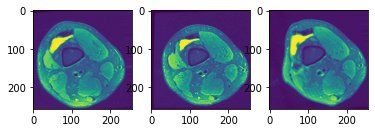

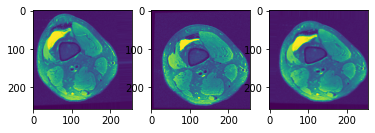

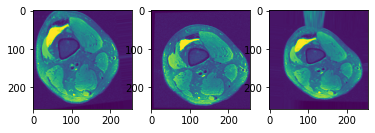

[[ 8.96632277e-01  2.30097928e-02  2.03228478e-02 -4.28764838e+00
  -2.52074551e-02  1.04698310e+00 -7.32695772e-02 -7.38280830e-01
  -2.48437476e-02  7.05205065e-02  1.01624752e+00 -1.92516506e+01]
 [ 1.00249854e+00  5.27955259e-02  3.89778135e-02 -3.22256885e+00
  -5.16925265e-02  1.01838346e+00 -4.98850039e-02 -1.47596048e+01
  -3.89040507e-02  4.41123730e-02  9.40851082e-01 -2.81715187e+01]
 [ 9.90210542e-01  2.65969118e-02  5.47419477e-02 -2.59120422e+00
  -2.38144135e-02  1.13318032e+00 -1.19795040e-01 -2.22977281e+01
  -5.56208685e-02  1.00053641e-01  9.57497033e-01 -2.98626971e+01]]
tf.Tensor(
[[ 9.8910958e-01  1.1565503e-01 -2.6168829e-01 -4.4006667e+00
  -2.1802108e-01  9.8089480e-01  8.2571805e-03 -8.2441473e-01
  -1.0170368e-01 -6.8268500e-02  1.0285376e+00 -1.8654850e+01]
 [ 1.0650613e+00  5.4699052e-02  5.5808529e-02 -3.1959543e+00
  -2.1395262e-01  1.0847647e+00 -6.1622471e-02 -1.4674562e+01
  -8.9088209e-02  2.4541162e-02  9.2295957e-01 -2.7739904e+01]
 [ 1.0194007e+00 

In [ ]:
"""
[[  1.00689002,   0.03654493,   0.03717216,  -3.63084558,
         -0.03239803,   0.99700621,  -0.10274288, -13.29430743,
         -0.0404979 ,   0.10132211,   0.9975384 , -16.55750802]]
"""
moving_test, label_test = next(dataGen)
num_show = 3
moving_test, gt_trf = moving_test[:num_show], label_test[1][:num_show]
(warped_test, affine_pred_test) = testModel(moving_test)

for i in range(num_show):
    fig, axes = plt.subplots(1,3)
    axes[0].imshow(moving_test[i,1,:,:,0]) # M
    axes[1].imshow(moving_test[i,1,:,:,1]) # F
    axes[2].imshow(warped_test[i,1,:,:,0])
    plt.show()

print(gt_trf)
print(affine_pred_test)

In [ ]:
## diff
dataGen = data_generator(batchSize=4)
diff = evaluate_model(testModel, dataGen, num=50)
print("diff: ", diff)

  0%|          | 0/50 [00:00<?, ?it/s]

diff:  {'trans': 0.07483823512359757, 'rot': 0.1719298778355164, 'scale': nan, 'shear': nan, 'tsf_param_mse': 0.14765696715753665, 'img_mse': 0.03475191909207127}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice.


#### Debug result for modified model 1
Trained with:  
* 20 epoch, 100 iterations/epoch, 8 batchsize/iter
* lr 0.0001
* does not include warped_image as loss
* lrelu, alpha = 0.1? 0.01?

Result: converge to a fixed feature layer and trans mat

[[  1.01307884   0.04695047   0.05647605  -3.06879812  -0.04671235
    1.07687879  -0.05731049  -0.30486862  -0.05709557   0.04982545
    0.98277023 -17.79652506]
 [  1.01553937   0.04557165   0.04181016  -6.26352387  -0.04745814
    1.11552157  -0.06315577 -15.07738272  -0.04337833   0.05444641
    0.99428441 -21.08516239]
 [  1.16565734   0.02999379   0.04155809  -1.41275025  -0.02162385
    0.99185049  -0.10932547 -12.91094143  -0.0350791    0.0997521
    0.91193496  -2.26271549]]
tf.Tensor(
[[  0.9247373    0.11367744   0.05949632  -3.6759      -0.09295747
    0.9371287   -0.06350692  -9.7160015   -0.06959302   0.06688026
    0.85883665 -16.67128   ]
 [  0.9479564    0.10165794   0.07214145  -3.7683585   -0.09284243
    0.969339    -0.05306562  -9.9907055   -0.07557572   0.06122331
    0.87892294 -17.10369   ]
 [  0.9869215    0.1143422    0.07018188  -3.929672    -0.09881708
    1.001384    -0.0471619  -10.410757    -0.06640584   0.06057689
    0.9249784  -17.80829   ]], shape=(3,

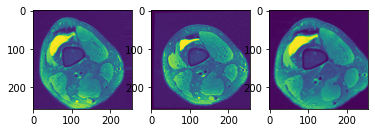

In [ ]:
"""
[[  1.00689002,   0.03654493,   0.03717216,  -3.63084558,
         -0.03239803,   0.99700621,  -0.10274288, -13.29430743,
         -0.0404979 ,   0.10132211,   0.9975384 , -16.55750802]]
"""
moving_test, label_test = next(dataGen)
num_show = 3
moving_test, gt_trf = moving_test[:num_show], label_test[1][:num_show]
(warped_test, affine_pred_test) = testModel(moving_test)

fig, axes = plt.subplots(1,3)
axes[0].imshow(moving_test[0,1,:,:,0])
axes[1].imshow(moving_test[0,1,:,:,1])
axes[2].imshow(warped_test[0,1,:,:,0])

print(gt_trf)
print(affine_pred_test)

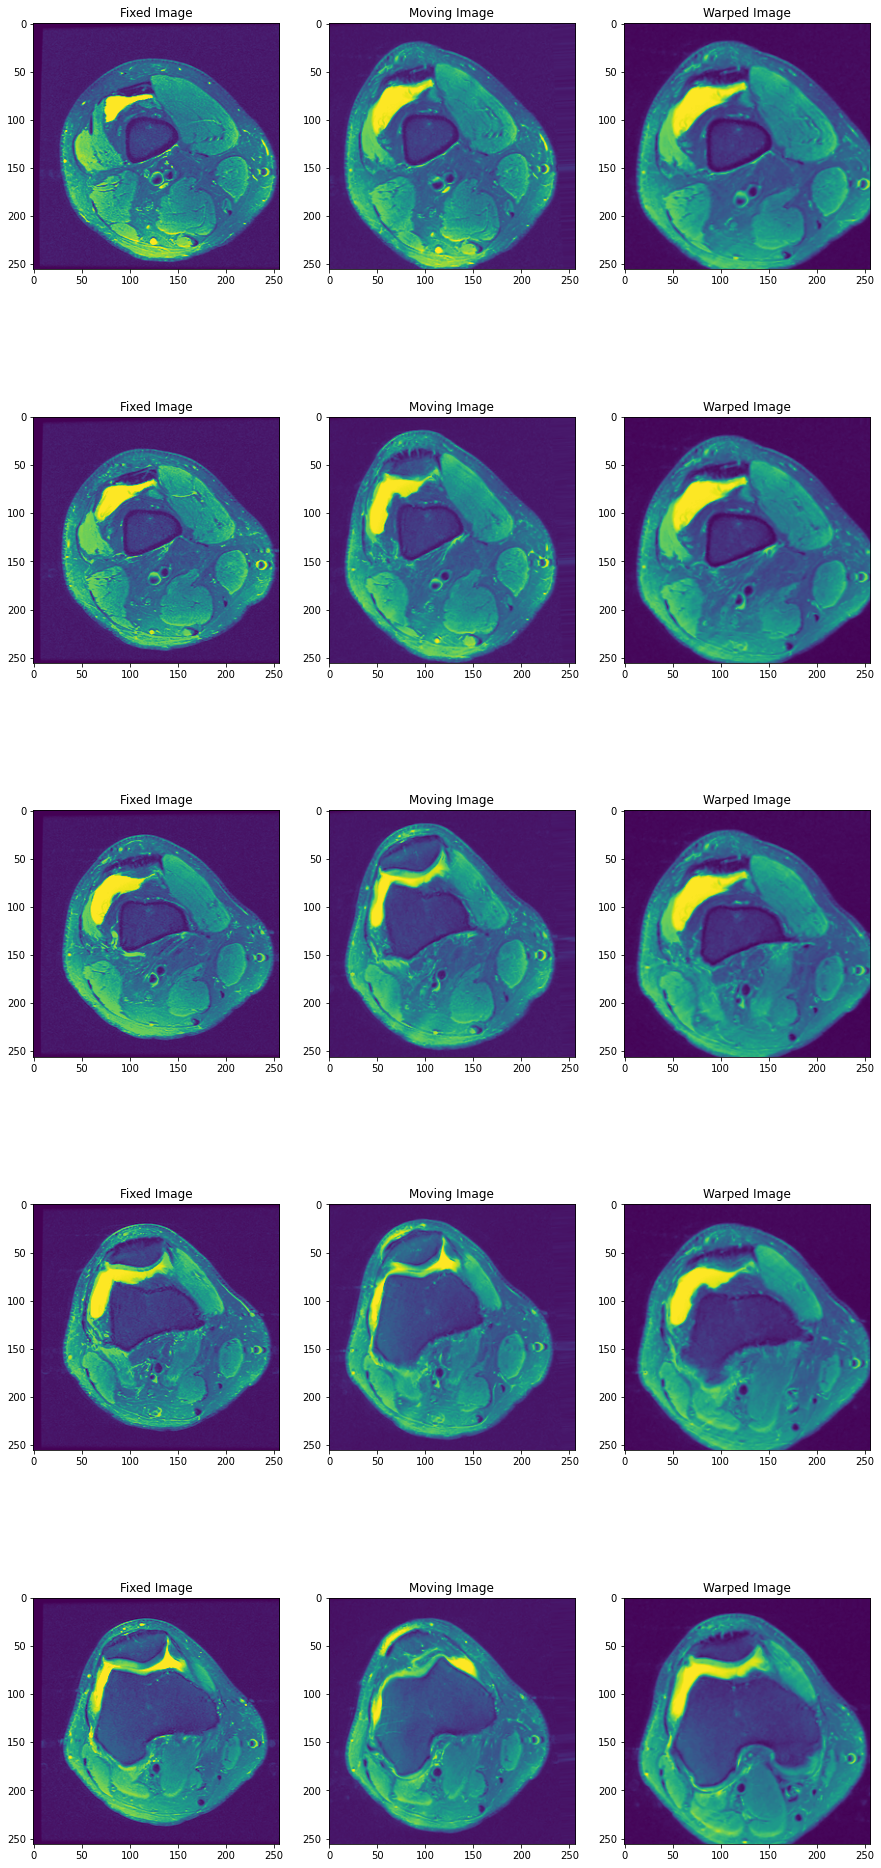

In [ ]:
sliceToCheck = 0
fig, axs = plt.subplots(5, 3, figsize=(15, 35))
for i in range(5):
    axs[i, 0].imshow(fixedImg[0,sliceToCheck + i * 5,:,:,0])
    axs[i, 0].set_title("Fixed Image")
    axs[i, 1].imshow(moving_test[0,sliceToCheck + i * 5,:,:,0])
    axs[i, 1].set_title("Moving Image")
    axs[i, 2].imshow(warped_test[0,sliceToCheck + i * 5,:,:,0])
    axs[i, 2].set_title("Warped Image")
plt.show()

In [ ]:
## 3 view hidden layer outputs values
## https://stackoverflow.com/questions/41711190/keras-how-to-get-the-output-of-each-layer
inp = testModel.input                                           # input placeholder
names = [layer.name for layer in testModel.layers]
outputs = [layer.output for layer in testModel.layers]          # all layer outputs
functor = K.function([inp], outputs)   # evaluation function

# Testing
moving_test, label_test = next(dataGen)
num_show = 3
moving_test, gt_trf = moving_test[:num_show], label_test[1][:num_show]
# (warped_test, affine_pred_test) = testModel(moving_test)
layer_outs = functor([moving_test])
print("Total:", len(layer_outs))
# print(layer_outs[-1].shape, layer_outs[-1])
num_display = 32
last_layer = -26
for i in range(-2,last_layer,-1):
    print(f"==> Layer {i}: {names[i]}", layer_outs[i].shape)
    if layer_outs[i][0].size <= num_display:
        print(f"<{num_display}", layer_outs[i].reshape((num_show, -1)))
    else:
        print(f">{num_display}", layer_outs[i].reshape((num_show, -1))[:, :num_display])
flat1 = layer_outs[-6]

Total: 26
==> Layer -2: affine_pred (3, 12)
<32 [[  0.93072045   0.10536972   0.0678002   -3.708314    -0.09176931
    0.9486078   -0.05230941  -9.80652     -0.06855953   0.06006256
    0.8634623  -16.797777  ]
 [  0.9245379    0.10793729   0.06425587  -3.6796176   -0.09175465
    0.9401885   -0.05818095  -9.728274    -0.06912465   0.0630937
    0.8562052  -16.67839   ]
 [  0.89828247   0.11130938   0.05677251  -3.5748327   -0.09092507
    0.91088504  -0.0635468   -9.432624    -0.06706191   0.06607191
    0.8303194  -16.192625  ]]
==> Layer -3: dense_5 (3, 64)
>32 [[-4.785629   -2.229453   -2.1108272  -2.5719826  -0.9488164  -5.0714436
  -2.284449   -2.8829417  -0.6975332  -3.6147463  -2.0171328  -1.9428521
  -2.9763026  -1.8965143  -5.4362607  -7.9871006  -7.7970767  -1.2598281
  -1.7856145  -2.8420324  -6.613984   -2.5303967  -0.46074018 -4.6359496
  -1.697007   -2.1841981  -1.4382288  -3.7763968  -7.4854584  -2.7062917
  -1.8627506  -3.7713747 ]
 [-4.7499213  -2.2135408  -2.0939445 

#### Debug result for original model

Process:
1. a random initialized model produces diff outputs
2. check weight: all trained weights are not all zeros
3. check output of trained hidden layers: 
    - dense layers receive the same input !
    - the feature encoding of the moving image converges to a fixed feature map (lots of zeros) 
    - dying Relu problem? try to change activation?
    - rotation representation problem?
    - not enough iterations?
4. change relu to lrelu(alpha=0.01 or 0.1), still converge to a fixed feature maps after some conv3d and maxpool layers
    - not problem of relu but problem of rotation representation?
    - test data generated without rotation?


In [ ]:
for layer in testModel.layers: 
    # print(layer.get_config(), layer.get_weights())
    ### 2 check weight
    if "dense" in layer.name or "affine_pred" in layer.name or "conv" in layer.name:
        print("----", layer.name, "weight_shape:", len(layer.get_weights()), layer.get_weights()[0].shape, layer.get_weights()[1].shape)
        print(np.allclose(layer.get_weights()[0], 0), np.allclose(layer.get_weights()[1], 0))
    # if "dense" in layer.name or "affine_pred" in layer.name:
        # print(layer.get_weights())
        # print(layer.input.shape, layer.output.shape)
        # print(layer.output)

---- conv3d_20 weight_shape: 2 (6, 32, 32, 1, 4) (4,)
False False
---- conv3d_25 weight_shape: 2 (6, 32, 32, 1, 4) (4,)
False False
---- conv3d_21 weight_shape: 2 (6, 16, 16, 4, 8) (8,)
False False
---- conv3d_26 weight_shape: 2 (6, 16, 16, 4, 8) (8,)
False False
---- conv3d_22 weight_shape: 2 (6, 8, 8, 8, 16) (16,)
False False
---- conv3d_27 weight_shape: 2 (6, 8, 8, 8, 16) (16,)
False False
---- conv3d_23 weight_shape: 2 (4, 8, 8, 16, 24) (24,)
False False
---- conv3d_28 weight_shape: 2 (4, 8, 8, 16, 24) (24,)
False False
---- conv3d_24 weight_shape: 2 (4, 4, 4, 24, 32) (32,)
False False
---- conv3d_29 weight_shape: 2 (4, 4, 4, 24, 32) (32,)
False False
---- dense_6 weight_shape: 2 (77440, 1024) (1024,)
False False
---- dense_7 weight_shape: 2 (1024, 256) (256,)
False False
---- dense_8 weight_shape: 2 (256, 64) (64,)
False False
---- affine_pred weight_shape: 2 (64, 12) (12,)
False False


In [ ]:
## 3 view hidden layer outputs values
## https://stackoverflow.com/questions/41711190/keras-how-to-get-the-output-of-each-layer
inp = testModel.input                                           # input placeholder
names = [layer.name for layer in testModel.layers]
outputs = [layer.output for layer in testModel.layers]          # all layer outputs
functor = K.function([inp], outputs)   # evaluation function

# Testing
moving_test, label_test = next(dataGen)
# (warped_test, affine_pred_test) = testModel(moving_test)
layer_outs = functor([moving_test])
print("Total:", len(layer_outs))
# print(layer_outs[-1].shape, layer_outs[-1])
num_display = 126
last_layer = -26
for i in range(-2,last_layer,-1):
    print(f"==> Layer {i}: {names[i]}", layer_outs[i].shape)
    if layer_outs[i].size <= num_display:
        print(f"<{num_display}", layer_outs[i].flatten())
    else:
        print(f">{num_display}", layer_outs[i].flatten()[:num_display])
flat1 = layer_outs[-6]

Total: 26
==> Layer -2: affine_pred (1, 12)
<126 [ 1.1727384e+00  1.7395984e-01  5.4577418e-02 -3.1152835e+00
 -5.1756445e-02  1.1091778e+00 -1.5948440e-01 -1.1458757e+01
  9.9163363e-03  1.8571476e-02  1.0320766e+00 -1.3764733e+01]
==> Layer -3: dense_8 (1, 64)
<126 [ 0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         3.0663462
  0.         0.         0.         0.         4.0462074  1.8267351
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         6.129323   0.         0.
 10.135203  10.120459   0.         0.         0.         0.
  0.         0.         4.7288237  4.4399085  0.         0.
 12.414728   0.         0.         4.0622296  0.         0.
  0.         0.         0.         0.         0.         0.
  0.        10.491759   0.         6.56872    0.         2.8780391
  0.         0.         4.017658   2.296172 ]
==> Layer -4: dense_7 (1, 256)
>126 [2.6012566  7.3405604  0.    

In [ ]:
# Testing
moving_test, label_test = next(dataGen)
layer_outs = functor([moving_test])
print("Total:", len(layer_outs))
for i in range(-2,last_layer,-1):
    print(f"==> Layer {i}: {names[i]}", layer_outs[i].shape)
    if layer_outs[i].size <= num_display:
        print(f"<{num_display}", layer_outs[i].flatten())
    else:
        print(f">{num_display}", layer_outs[i].flatten()[:num_display])
flat2 = layer_outs[-6]

Total: 26
==> Layer -2: affine_pred (1, 12)
<126 [ 1.1727384e+00  1.7395984e-01  5.4577418e-02 -3.1152835e+00
 -5.1756445e-02  1.1091778e+00 -1.5948440e-01 -1.1458757e+01
  9.9163363e-03  1.8571476e-02  1.0320766e+00 -1.3764733e+01]
==> Layer -3: dense_8 (1, 64)
<126 [ 0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         3.0663462
  0.         0.         0.         0.         4.0462074  1.8267351
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         6.129323   0.         0.
 10.135203  10.120459   0.         0.         0.         0.
  0.         0.         4.7288237  4.4399085  0.         0.
 12.414728   0.         0.         4.0622296  0.         0.
  0.         0.         0.         0.         0.         0.
  0.        10.491759   0.         6.56872    0.         2.8780391
  0.         0.         4.017658   2.296172 ]
==> Layer -4: dense_7 (1, 256)
>126 [2.6012566  7.3405604  0.    

In [ ]:
np.allclose(flat1, flat2)

True

[[  0.95796721   0.06759928   0.03561585  -4.08532835  -0.06171287
    0.92737492  -0.10026351  -8.25192058  -0.04846884   0.11427287
    1.08678564 -27.43916151]]
tf.Tensor(
[[ 1.1727384e+00  1.7395984e-01  5.4577418e-02 -3.1152835e+00
  -5.1756445e-02  1.1091778e+00 -1.5948440e-01 -1.1458757e+01
   9.9163363e-03  1.8571476e-02  1.0320766e+00 -1.3764733e+01]], shape=(1, 12), dtype=float32)


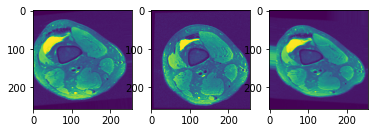

In [ ]:
"""
[[  1.00689002,   0.03654493,   0.03717216,  -3.63084558,
         -0.03239803,   0.99700621,  -0.10274288, -13.29430743,
         -0.0404979 ,   0.10132211,   0.9975384 , -16.55750802]]
"""
moving_test, label_test = next(dataGen)
(warped_test, affine_pred_test) = testModel(moving_test)

fig, axes = plt.subplots(1,3)
axes[0].imshow(moving_test[0,1,:,:,0]) # M
axes[1].imshow(moving_test[0,1,:,:,1]) # F
axes[2].imshow(warped_test[0,1,:,:,0])

print(label_test[1])
print(affine_pred_test)

[[  0.88378472   0.0575234    0.06490466  -3.78928535  -0.05013974
    0.88283919  -0.0997027  -23.42505913  -0.07183986   0.0967141
    0.89250367 -22.70701654]]
tf.Tensor(
[[ 1.1727384e+00  1.7395984e-01  5.4577418e-02 -3.1152835e+00
  -5.1756445e-02  1.1091778e+00 -1.5948440e-01 -1.1458757e+01
   9.9163363e-03  1.8571476e-02  1.0320766e+00 -1.3764733e+01]], shape=(1, 12), dtype=float32)


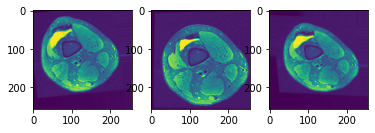

In [ ]:
moving_test, label_test = next(dataGen)
(warped_test, affine_pred_test) = testModel(moving_test)

fig, axes = plt.subplots(1,3)
axes[0].imshow(moving_test[0,1,:,:,0])
axes[1].imshow(moving_test[0,1,:,:,1])
axes[2].imshow(warped_test[0,1,:,:,0])

print(label_test[1])
print(affine_pred_test)

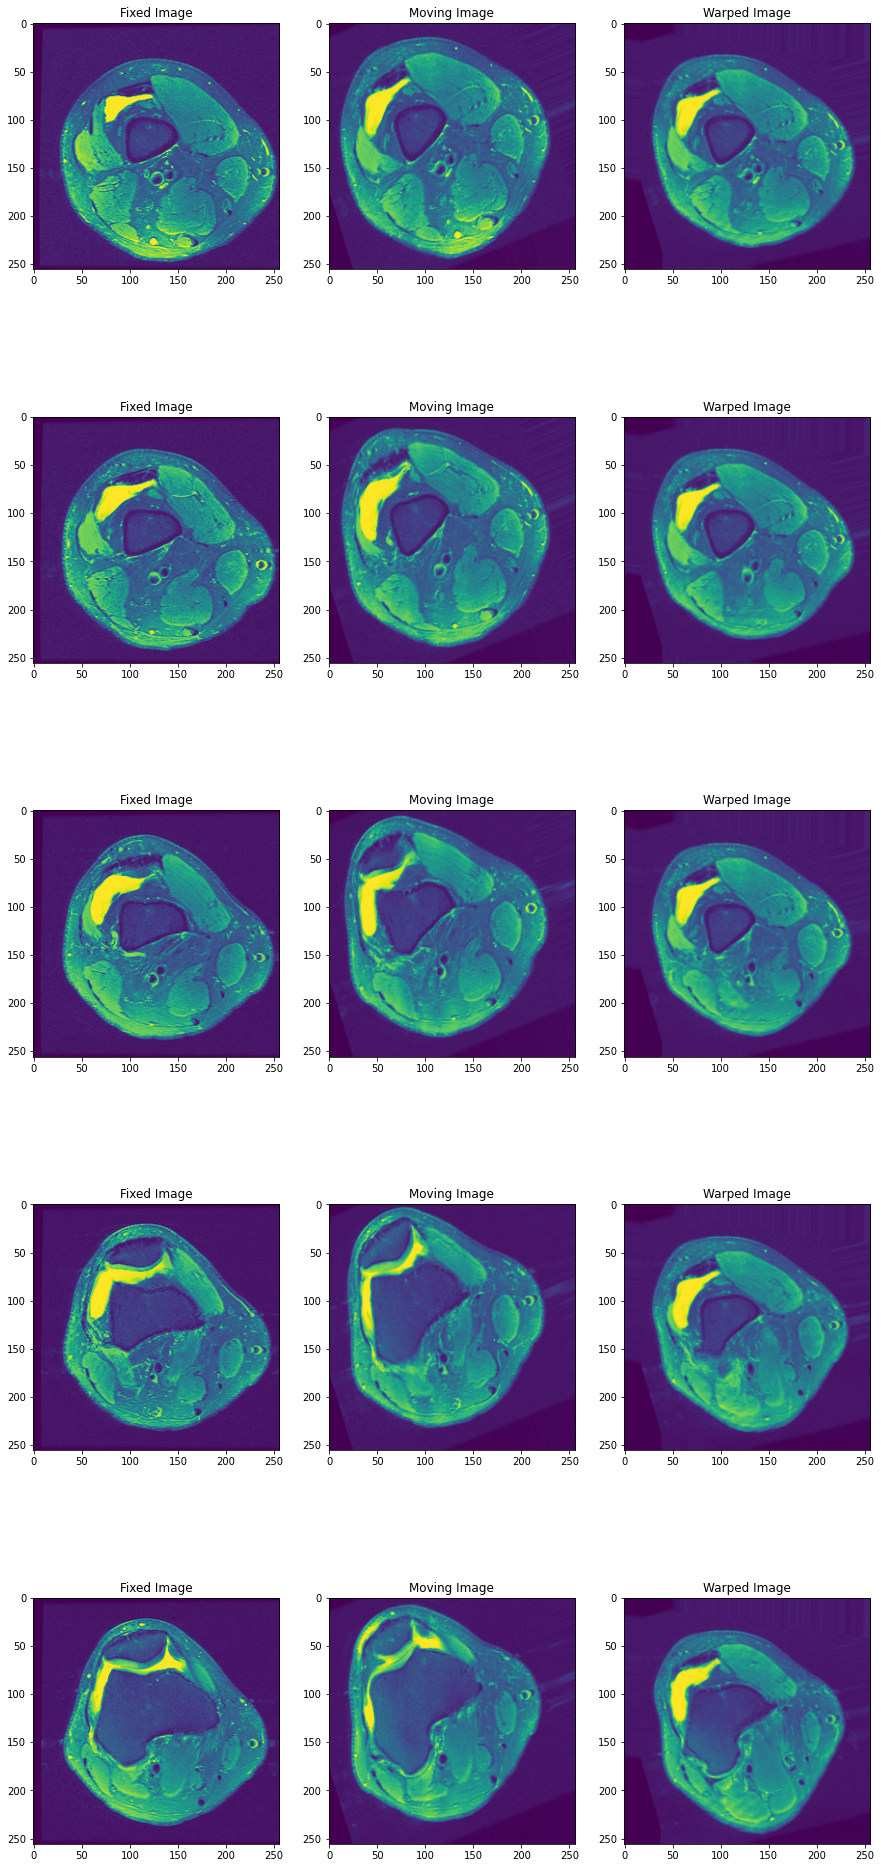

In [ ]:
sliceToCheck = 0
fig, axs = plt.subplots(5, 3, figsize=(15, 35))
for i in range(5):
    axs[i, 0].imshow(fixedImg[0,sliceToCheck + i * 5,:,:,0])
    axs[i, 0].set_title("Fixed Image")
    axs[i, 1].imshow(moving_test[0,sliceToCheck + i * 5,:,:,0])
    axs[i, 1].set_title("Moving Image")
    axs[i, 2].imshow(warped_test[0,sliceToCheck + i * 5,:,:,0])
    axs[i, 2].set_title("Warped Image")
plt.show()

#### Old debug result

In [ ]:
moving_test, label_test = next(dataGen)
(warped_test, affine_pred_test) = testModel(moving_test)
print(label_test[1])
print(affine_pred_test)

[[ 9.97783354e-01  2.81807946e-02  5.97546391e-02 -2.36656929e+00
  -1.86507086e-02  1.03671288e+00 -1.77492932e-01 -2.16959668e+01
  -6.78998079e-02  1.78480907e-01  1.04961833e+00 -2.92642264e+01]]
tf.Tensor(
[[ 9.3246776e-01 -9.5513612e-03  8.3614871e-02 -3.7436948e+00
  -3.2481186e-02  1.0323266e+00 -3.4798801e-02 -1.4669796e+01
  -1.9191064e-02  6.1604641e-02  1.0701416e+00 -1.5027257e+01]], shape=(1, 12), dtype=float32)


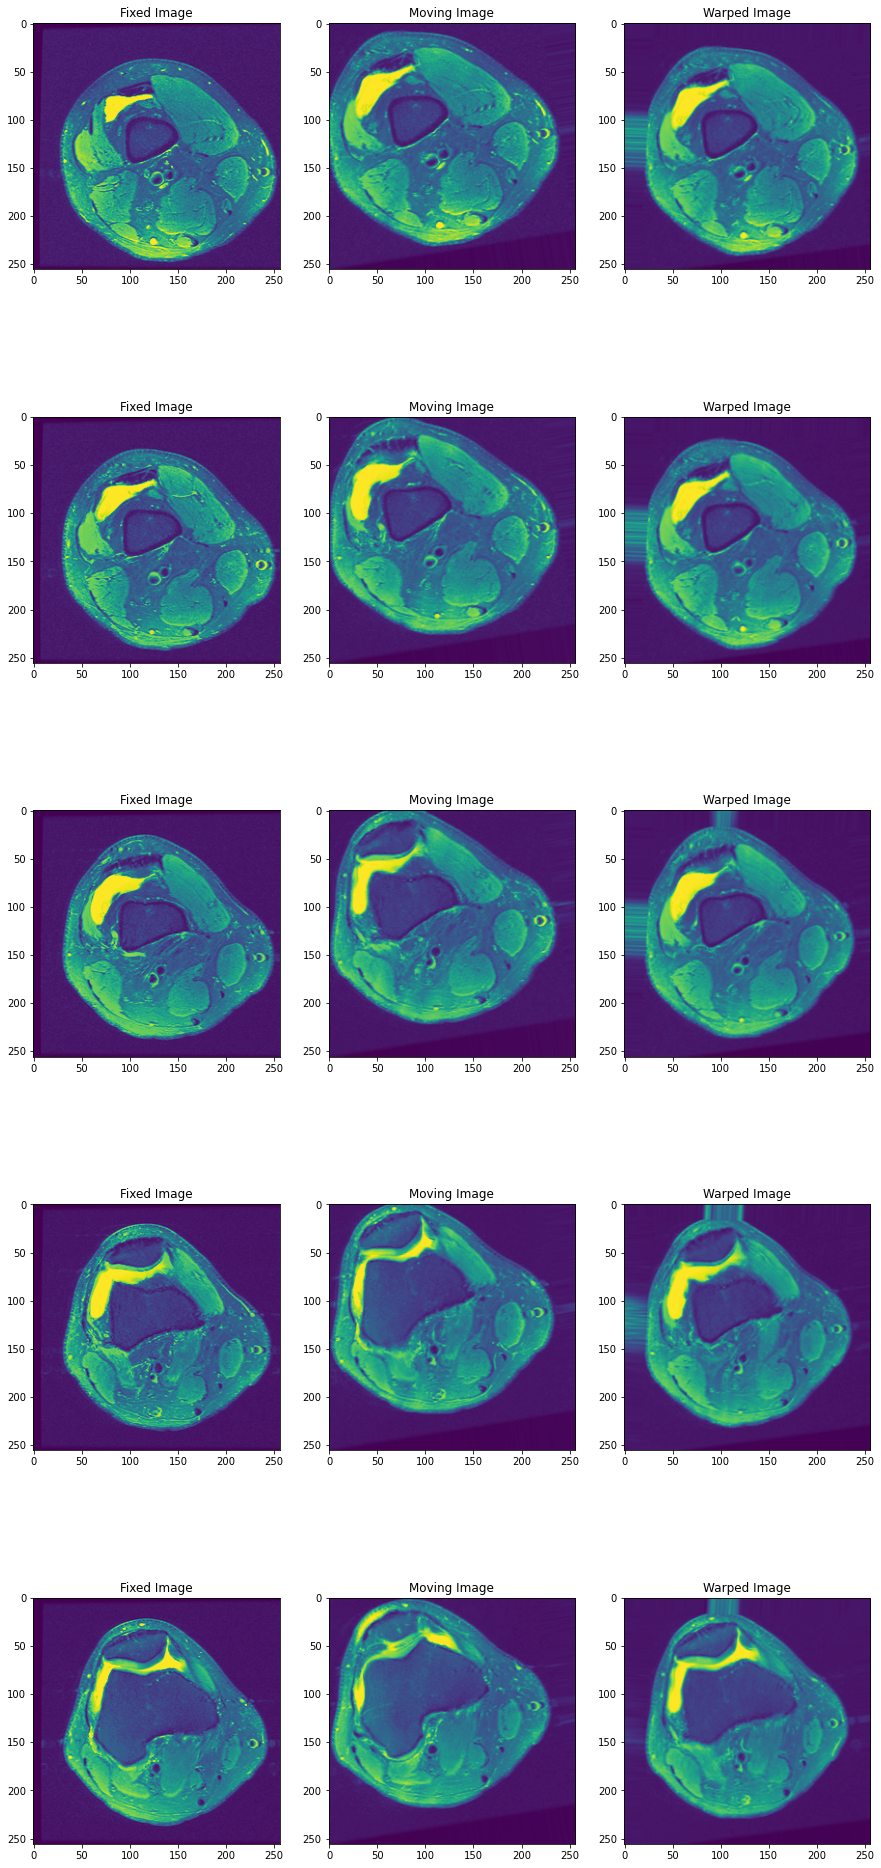

In [ ]:
sliceToCheck = 0
fig, axs = plt.subplots(5, 3, figsize=(15, 35))
for i in range(5):
    axs[i, 0].imshow(fixedImg[0,sliceToCheck + i * 5,:,:,0])
    axs[i, 0].set_title("Fixed Image")
    axs[i, 1].imshow(moving_test[0,sliceToCheck + i * 5,:,:,0])
    axs[i, 1].set_title("Moving Image")
    axs[i, 2].imshow(warped_test[0,sliceToCheck + i * 5,:,:,0])
    axs[i, 2].set_title("Warped Image")
plt.show()